# Supervised Learning Project: Binary Prediction of Smoker Status

## 1. Problem Definition and Dataset Choice

**Dataset Choice:** H) Binary Prediction of Smoker Status using Bio-Signals. (Source: `train.csv` from https://www.kaggle.com/competitions/playground-series-s3e24/data?select=train.csv)

----------------------------------------------

### **Problem Definition**
The goal of this project is to solve a supervised learning problem, focused essentially in binary classification. We aim to develop a predictive model capable of accurately assigning an individual to one of two distinct categories: Smoker or Non-Smoker.

- **Target Variable**: The target variable in this study is a Smoker Status, a categorical variable with two possible classes:
Positive Class: Smoker;
Negative Class: Non-Smoker

- **Input Data**: Our model’s input data is a bio-signals dataset. These are physiological measures that are indicators of different activities in the body. The bio-signals that are incorporated for this project are age, height, weight, eyesight, hearing and systolic blood pressure . Our dataset will consist of a set of bio-signal features for each individual.

Our interest will be on testing strong machine learning models that would learn all the complex associations between these bio-signals and the individual’s status as a smoker, in a purely data-driven way of prediction.

----------------------------------------------

### **Methodology Justification**

- **Tools and Libraries**: We will use Python and make use of the Pandas library for data manipulation, NumPy for numerical calculations and Scikit-learn for the implementation of various machine learning algorithms and evaluation metrics. The PyTorch framework will be used to implement the Neural Network. Matplotlib will be used for data visualization to explore the data and present model performance.

- **Algorithms**: In order to solve the binary classification problem of predicting smoker status, we have chosen to implement and compare the following supervised learning algorithms:

  -- **Decision Tree**: This tree based algorithm will be a possibly interpretable baseline model that is able to represent non-linear decision boundaries via a series of sequential rules.

  -- **k-Nearest Neighbors (k-NN)**: This non-parametric approach will assign a classification to an individual according to the smoker status of the closest neighbors in the bio-signal feature space, thus allowing to evaluate the significance of local patterns in the data.

  -- **Support Vector Machine (SVM)**: This algorithm tries to find the best boundary that separates smokers from non-smokers. It works well for high-dimensional data and can handle non-linear patterns using kernel functions.

  -- **Neural Network (NN)**: A feedforward neural network architecture will be investigated using PyTorch to learn complex, non-linear relationships in the bio-signal data. This will help us see what a more sophisticated model can do.



- **Metrics**: Our deployed models will be assessed using the following standard classification metrics:

- **Accuracy**: To assess the general correctness of the predictions.
Precision: To evaluate the model’s capability of not predicting non-smokers as smokers.
Recall (Sensitivity): Used to evaluate the model’s performance in identifying all smokers.
F1-score: In order to balance precision and recall.
Confusion Matrix: Used to display the distribution of true positives, true negatives, false positives, and false negatives.
Training and Testing Times: To assess the computational expense of training and predicting with each model.

----------------------------------------------

### **Related Work:**

James, G., Witten, D., Hastie, T., Tibshirani, R. (2013). An Introduction to Statistical Learning. Springer.
https://www.statlearning.com/  

Moosavian, A., Ahmadi, H., Tabatabaeefar, A., & Khazaee, M. (2013). Comparison of Two Classifiers; K-Nearest Neighbor and Artificial Neural Network, for Fault Diagnosis on a Main Engine Journal-Bearing. Shock and Vibration, 20(2), 263–272.
https://doi.org/10.3233/SAV-2012-00742

Quinlan, J. R. (1993). C4.5: Programs for Machine Learning. Morgan Kaufmann Publishers

Cohen, G., Sapiro, G., & Giryes, R. (2018). DNN or k-NN: That is the Generalize vs. Memorize Question. arXiv preprint arXiv:1805.06822. https://arxiv.org/abs/1805.06822

Scikit-learn Documentation: “Supervised Learning Models.”
https://scikit-learn.org/stable/supervised_learning.html

Matplotlib Documentation: Visualization Libraries.
https://matplotlib.org/stable/contents.html

Towards Data Science, “Exploratory Data Analysis in Python.”
https://towardsdatascience.com/exploratory-data-analysis-in-python-c9a77dfa39ce

Qananwah, Q., Quran, H., Dagamseh, A. et al. Investigating the correlation between smoking and blood pressure via photoplethysmography. BioMed Eng OnLine 24, 57 (2025). https://doi.org/10.1186/s12938-025-01373-w

Thwin, D. (2023). Binary Prediction of Smoker Status using Bio-Signals – Report. Medium.
https://medium.com/@daran.thw/iccs463-binary-prediction-of-smoker-status-using-bio-signals-report-e66878f08ac3
Okka, A. (2023). Binary Prediction of Smoker Status using Bio-Signals. GitHub Repository.
https://github.com/ahmedokka29/Binary-Prediction-of-Smoker-Status-using-Bio-Signals

## 2. Import of all the necessary libraries for the project.
Import all necessary libraries for the project.

In [6]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, roc_auc_score, roc_curve

from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree, export_text

from sklearn.tree import plot_tree, export_text
from sklearn.inspection import permutation_importance
import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

## 3. Data Loading
Load the dataset to be used across the project.

In [7]:
!git clone https://github.com/bernas013/Project2-AI.git

try:
    train_df_original = pd.read_csv('Project2-AI/train.csv')
    train_df = train_df_original.copy()
    print("Training data loaded successfully!")
except FileNotFoundError:
    print("Error: train.csv not found. Make sure the file is in the correct directory.")
    train_df = None


fatal: destination path 'Project2-AI' already exists and is not an empty directory.
Training data loaded successfully!


## 4. Exploratory Data Analysis (EDA)

\n--- First few rows of the training data ---
   id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0   55         165          60       81.0             0.5   
1   1   70         165          65       89.0             0.6   
2   2   20         170          75       81.0             0.4   
3   3   35         180          95      105.0             1.5   
4   4   30         165          60       80.5             1.5   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...  HDL  LDL  \
0              0.6              1               1       135  ...   40   75   
1              0.7              2               2       146  ...   57  126   
2              0.5              1               1       118  ...   45   93   
3              1.2              1               1       131  ...   38  102   
4              1.0              1               1       121  ...   44   93   

   hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  \
0        16.5 

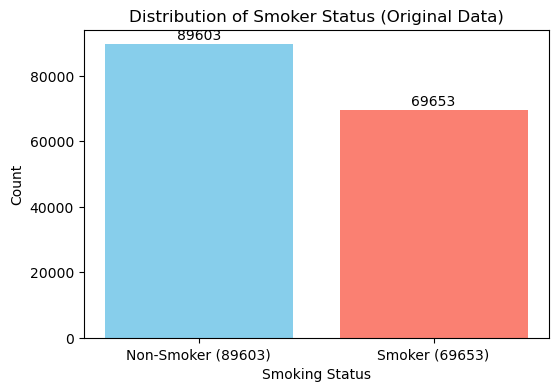

Imbalance Ratio (Non-Smoker/Smoker): 1.29:1


In [8]:
if train_df is not None:
    print("\\n--- First few rows of the training data ---")
    print(train_df.head())

    print("\\n--- Information about the dataset (Data Types, Non-Null Counts) ---")
    train_df.info()

    print("\\n--- Missing values in original train_df ---")
    missing_values = train_df_original.isnull().sum()
    print(missing_values[missing_values > 0])
    if missing_values.sum() == 0:
        print("No missing values found in the original dataset.")

    print("\\n--- Summary statistics of numerical features ---")
    print(train_df.describe()) #

    print("\\n--- Distribution of the target variable ('smoking') in Original Data ---")
    print(train_df['smoking'].value_counts()) #
    smoking_counts_original = train_df['smoking'].value_counts()
    plt.figure(figsize=(6, 4))
    bars = plt.bar(smoking_counts_original.index, smoking_counts_original.values, color=['skyblue', 'salmon'])
    plt.title('Distribution of Smoker Status (Original Data)')
    plt.xlabel('Smoking Status')
    plt.ylabel('Count')
    plt.xticks(smoking_counts_original.index, [f'Non-Smoker ({smoking_counts_original[0]})', f'Smoker ({smoking_counts_original[1]})'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 500, int(yval), va='bottom', ha='center', fontsize=10)
    plt.show()
    print(f"Imbalance Ratio (Non-Smoker/Smoker): {smoking_counts_original[0]/smoking_counts_original[1]:.2f}:1")


### Initial Exploration of a Few Bio-Signal Features (Histograms and Box Plots)
*(Visualizing distributions and relationships with the target variable.)*


--- Histograms of a few numerical features (Original Data) ---



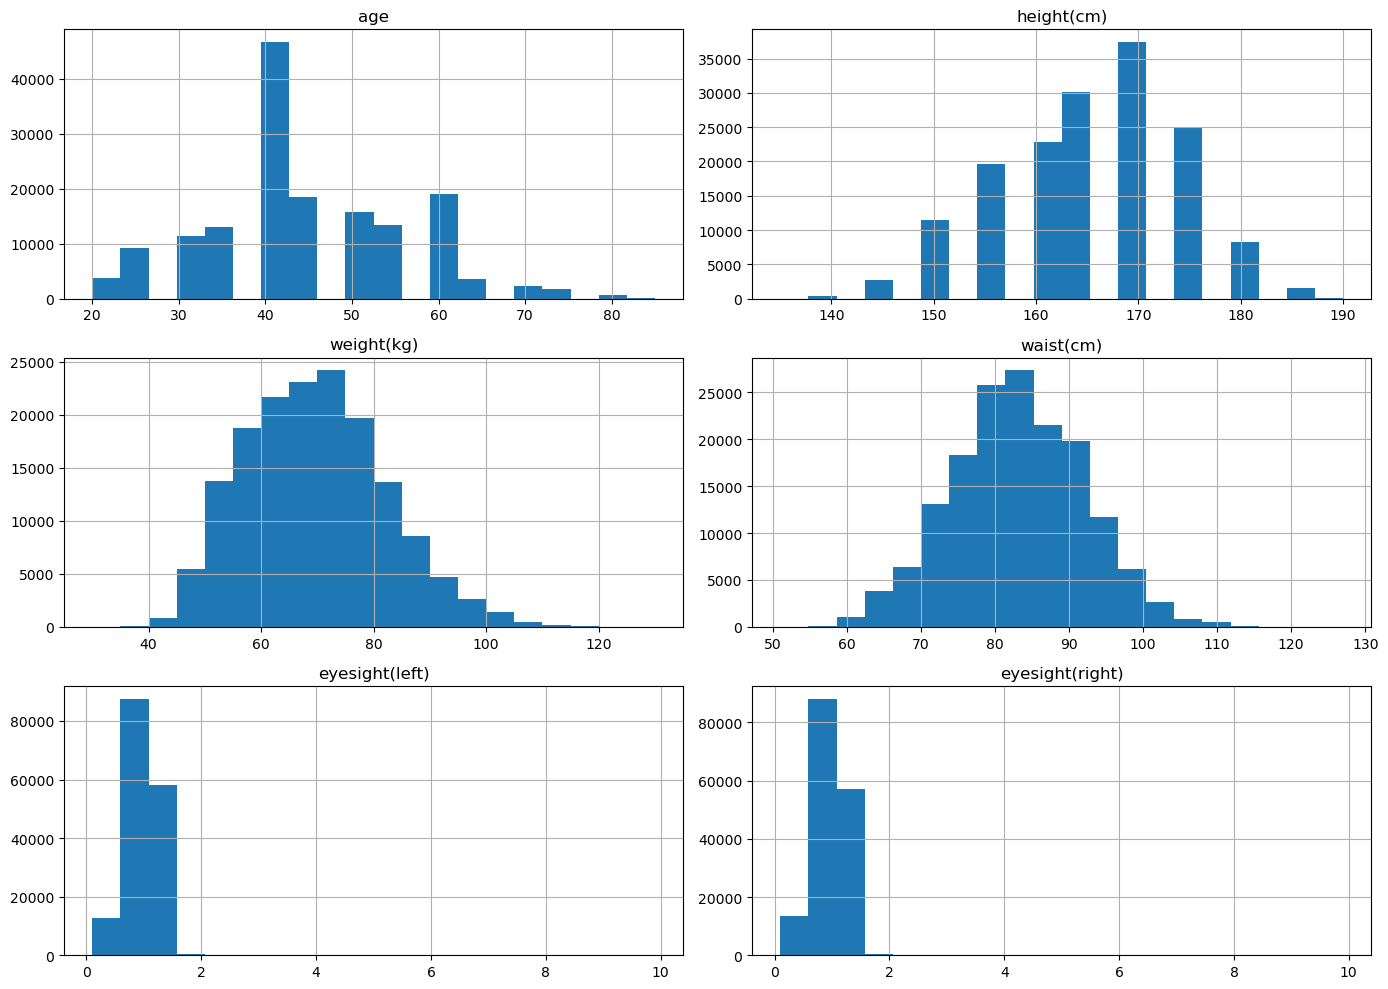


--- Box plots of a few numerical features vs. 'smoking' (Original Data) ---



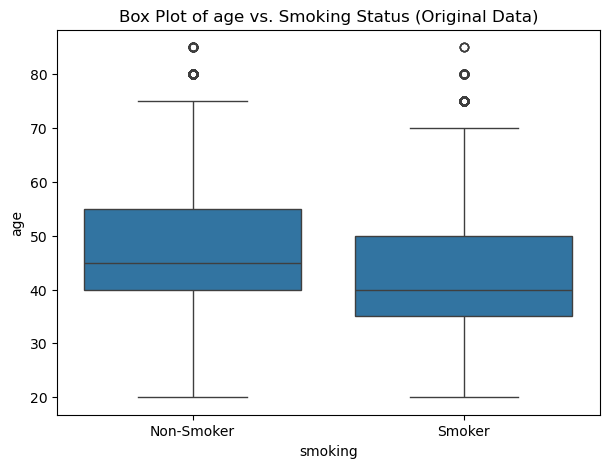

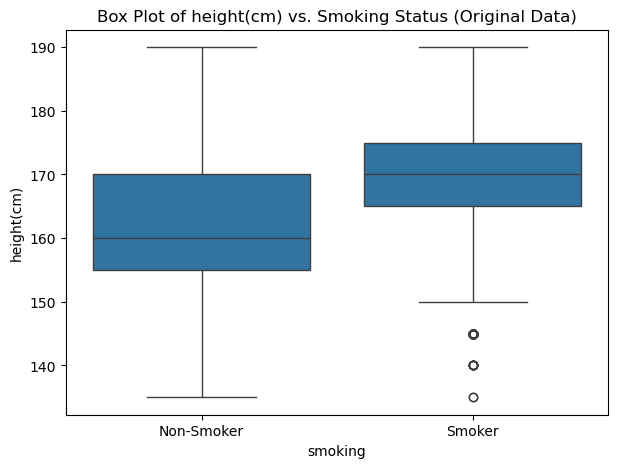

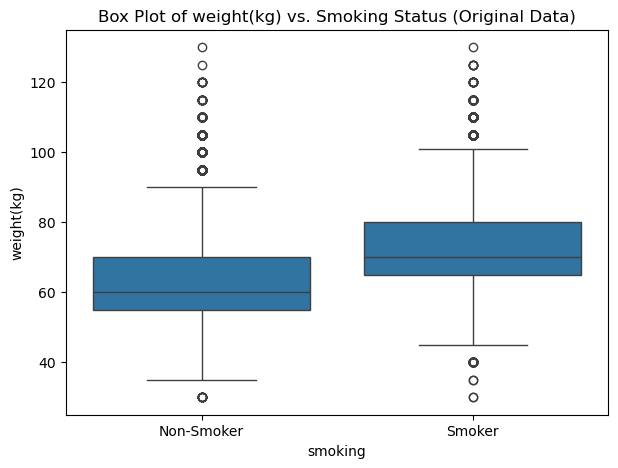

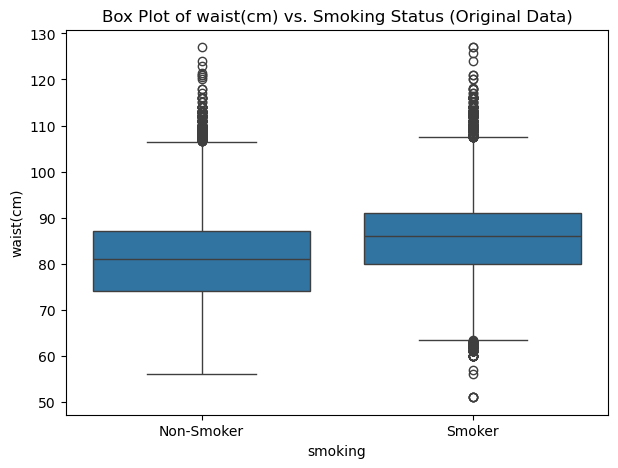

In [9]:
if train_df is not None:
    numerical_cols_eda = train_df.select_dtypes(include=np.number).columns.tolist()
    if 'id' in numerical_cols_eda:
        numerical_cols_eda.remove('id')
    if 'smoking' in numerical_cols_eda:
        numerical_cols_eda.remove('smoking')

    if numerical_cols_eda:
        print("\n--- Histograms of a few numerical features (Original Data) ---\n")
        num_to_plot_hist = min(6, len(numerical_cols_eda)) # Plot a few more
        train_df[numerical_cols_eda[:num_to_plot_hist]].hist(figsize=(14, 10), bins=20)
        plt.tight_layout()
        plt.show()

        print("\n--- Box plots of a few numerical features vs. 'smoking' (Original Data) ---\n")
        num_to_plot_box = min(4, len(numerical_cols_eda)) # Plot a few key ones
        for col in numerical_cols_eda[:num_to_plot_box]:
            plt.figure(figsize=(7, 5))
            sns.boxplot(x='smoking', y=col, data=train_df)
            plt.title(f'Box Plot of {col} vs. Smoking Status (Original Data)')
            plt.xticks([0,1],['Non-Smoker','Smoker'])
            plt.show()
            print("\n")


## 5. Data Preprocessing

### 5.1. Handling Class Imbalance (Random Undersampling)
The original dataset shows an imbalance. We'll use random undersampling of the majority class (non-smokers) to match the number of smokers. This helps prevent models from being biased towards the majority class.


--- Class distribution in the balanced DataFrame: --- 

smoking
1    69653
0    69653
Name: count, dtype: int64




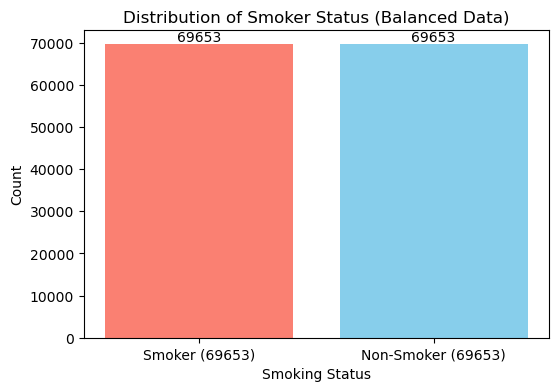

In [10]:
if train_df is not None:

    # Count the number of samples in each class
    smoker_count = train_df['smoking'].value_counts()[1]
    non_smoker_count = train_df['smoking'].value_counts()[0]

    # Identify the indices of each class
    smoker_indices = train_df[train_df['smoking'] == 1].index
    non_smoker_indices = train_df[train_df['smoking'] == 0].index

    # Randomly select non-smoker indices to match smoker count
    random_non_smoker_indices = np.random.choice(non_smoker_indices, smoker_count, replace=False)

    # Combine the smoker indices with the randomly selected non-smoker indices
    balanced_indices = np.concatenate([smoker_indices, random_non_smoker_indices])

    # Create a new balanced DataFrame
    balanced_df = train_df.loc[balanced_indices].sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the balanced df

    print("\n--- Class distribution in the balanced DataFrame: --- \n")
    print(balanced_df['smoking'].value_counts())
    print("\n")
    smoking_counts_balanced = balanced_df['smoking'].value_counts()
    plt.figure(figsize=(6, 4))
    bars = plt.bar(smoking_counts_balanced.index, smoking_counts_balanced.values, color=['skyblue', 'salmon'])
    plt.title('Distribution of Smoker Status (Balanced Data)')
    plt.xlabel('Smoking Status')
    plt.ylabel('Count')
    plt.xticks(smoking_counts_balanced.index, [f'Non-Smoker ({smoking_counts_balanced[0]})', f'Smoker ({smoking_counts_balanced[1]})'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 100, int(yval), va='bottom', ha='center') # Adjust 100 based on scale
    plt.show()
else:
    print("train_df is None. Skipping preprocessing.")


### 5.2. Feature and Target Separation, Train-Test Split
Separate features (X) and target (y). Then, split the data into training and validation sets. This is done *before* outlier handling and scaling to prevent data leakage from the validation set into the training process.

In [11]:
if balanced_df is not None:
    # Separate features (X) and target (y) from balanced_df
    X = balanced_df.drop(['smoking', 'id'], axis=1).copy() # Drop 'id' as it's not a feature
    y = balanced_df['smoking'].copy()

    # Identify numerical features for processing (all columns in X are currently numerical or treated as such)
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    print("\nNumerical features to be processed:", numerical_cols)

    # Handle missing values (Imputation with Median) - Applied again in case any were introduced or if not run before
    # This step is generally robust. Given the EDA showed no missing values in original, this is a safeguard.
    imputer = SimpleImputer(strategy='median')
    X[numerical_cols] = imputer.fit_transform(X[numerical_cols])
    print("\nMissing values imputed using the median (safeguard).")
    print("\nNumber of missing values in X after imputation:")
    print(X.isnull().sum().sum())


    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify by y
    print("\nData split into training and validation sets:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
else:
    print("balanced_df is None. Skipping train-test split.")


Numerical features to be processed: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']

Missing values imputed using the median (safeguard).

Number of missing values in X after imputation:
0

Data split into training and validation sets:
X_train shape: (111444, 22), y_train shape: (111444,)
X_val shape: (27862, 22), y_val shape: (27862,)


### 5.3. Outlier Handling (IQR-based Winsorizing)
Outliers can skew model training. We'll use IQR-based winsorizing. Bounds are calculated from the *training data only* and then applied to both training and validation sets to prevent data leakage.

In [12]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def winsorize_data_iqr(data, column, train_bounds):
    lower_bound, upper_bound = train_bounds

    data_winsorized = data.copy()
    data_winsorized[column] = np.where(data_winsorized[column] < lower_bound, lower_bound, data_winsorized[column])
    data_winsorized[column] = np.where(data_winsorized[column] > upper_bound, upper_bound, data_winsorized[column])
    return data_winsorized

if 'X_train' in locals():
    print("\n--- Applying IQR-based outlier winsorizing ---")
    X_train_winsorized = X_train.copy()
    X_val_winsorized = X_val.copy()

    outlier_bounds_map = {}

    for col in numerical_cols:
        lower, upper = detect_outliers_iqr(X_train, col)
        outlier_bounds_map[col] = (lower, upper)

        X_train_winsorized = winsorize_data_iqr(X_train_winsorized, col, (lower, upper))
        X_val_winsorized = winsorize_data_iqr(X_val_winsorized, col, (lower, upper))

    print("Outlier winsorizing (IQR) applied to training and validation data.")
    print("\n--- Sample of Winsorized Training Data --- \n")
    print(X_train_winsorized.head())
    print("\n--- Sample of Winsorized Validation Data --- \n")
    print(X_val_winsorized.head())
else:
    print("X_train not available. Skipping outlier handling.")


--- Applying IQR-based outlier winsorizing ---
Outlier winsorizing (IQR) applied to training and validation data.

--- Sample of Winsorized Training Data --- 

         age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
23716   55.0       165.0        60.0       76.4             1.2   
21791   45.0       165.0        65.0       86.2             1.2   
82248   60.0       170.0        70.0       82.0             0.5   
18808   55.0       155.0        55.0       86.0             1.5   
131104  40.0       175.0        75.0       85.0             1.5   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
23716               1.5            1.0             1.0     123.0        83.0   
21791               1.0            1.0             1.0     110.0        70.0   
82248               0.6            1.0             1.0     122.0        72.0   
18808               1.2            1.0             1.0     120.0        86.0   
131104              1.0            1

### 5.4. Feature Scaling (StandardScaler)
Scaling numerical features to have zero mean and unit variance. This is done *after* outlier handling and *after* train-test split, fitting the scaler only on training data.

In [13]:
if 'X_train_winsorized' in locals():
    scaler = StandardScaler()

    # Fit on training data and transform both training and validation data
    X_train_scaled_np = scaler.fit_transform(X_train_winsorized[numerical_cols])
    X_val_scaled_np = scaler.transform(X_val_winsorized[numerical_cols]) # Use transform for validation data

    # Convert scaled arrays back to DataFrames
    X_train_processed = pd.DataFrame(X_train_scaled_np, columns=numerical_cols, index=X_train_winsorized.index)
    X_val_processed = pd.DataFrame(X_val_scaled_np, columns=numerical_cols, index=X_val_winsorized.index)

    print("\nNumerical features scaled using StandardScaler (after outlier handling).\n")
    print("\nFirst few rows of final processed training features (X_train_processed):\n")
    print(X_train_processed.head())
    print("\nFirst few rows of final processed validation features (X_val_processed):\n")
    print(X_val_processed.head())

    print("\nFinal processed data shapes:")
    print(f"\nX_train_processed shape: {X_train_processed.shape}, y_train shape: {y_train.shape}")
    print(f"\nX_val_processed shape: {X_val_processed.shape}, y_val shape: {y_val.shape}")
else:
    print("X_train_winsorized not available. Skipping scaling.")

# Initialize dictionaries to store results for comparison
model_performance = {}
training_times = {}
validation_times = {}


Numerical features scaled using StandardScaler (after outlier handling).


First few rows of final processed training features (X_train_processed):

             age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
23716   1.008871   -0.090552   -0.619736  -0.777802        0.638512   
21791   0.100320   -0.090552   -0.213768   0.329199        0.638512   
82248   1.463146    0.488879    0.192201  -0.145230       -1.638419   
18808   1.008871   -1.249413   -1.025704   0.306607        1.614339   
131104 -0.353955    1.068309    0.598169   0.193648        1.614339   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
23716          1.630960            0.0             0.0  0.038341    0.683230   
21791         -0.001526            0.0             0.0 -1.006705   -0.784563   
82248         -1.307515            0.0             0.0 -0.042047   -0.558749   
18808          0.651468            0.0             0.0 -0.202824    1.021951   
131104        -0.001526

## 6. Model Implementation and Comparison


### 6.1. Decision Tree Classifier


--- Tuning Decision Tree ---
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best DT Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 2}

--- Training Best Decision Tree ---

Best Decision Tree model trained! Training time: 0.39 seconds

Best Decision Tree model validated! Validation time: 0.00 seconds

--- Best Decision Tree Validation Metrics ---

Accuracy: 0.7698
Precision: 0.7254
Recall: 0.8684
F1-Score: 0.7904
ROC-AUC: 0.8375



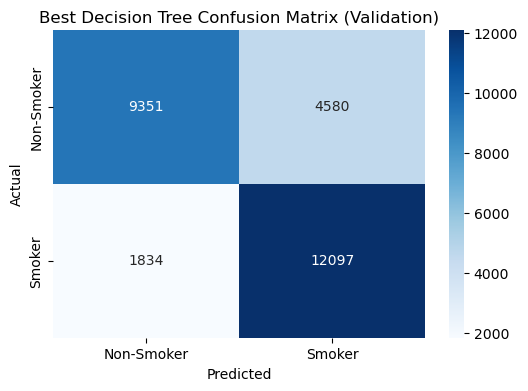

In [36]:
if 'X_train_processed' in locals():

    # --- Hyperparameter Tuning for Decision Tree (using GridSearchCV) ---
    print("\n--- Tuning Decision Tree ---")
    dt_param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 10, 20, 50],
        'min_samples_leaf': [1, 5, 10, 20]
    }
    dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

    # Uncomment the line below to run GridSearchCV
    dt_grid_search.fit(X_train_processed, y_train)
    print(f"Best DT Parameters: {dt_grid_search.best_params_}")
    best_dt_classifier = dt_grid_search.best_estimator_

    # best_dt_params = {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}
    # best_dt_classifier = DecisionTreeClassifier(**best_dt_params, random_state=42)

    # Train the best Decision Tree model
    print("\n--- Training Best Decision Tree ---")
    start_time_dt_train = time.time()
    best_dt_classifier.fit(X_train_processed, y_train)
    end_time_dt_train = time.time()
    training_time_dt = end_time_dt_train - start_time_dt_train
    training_times['Decision Tree'] = training_time_dt
    print(f"\nBest Decision Tree model trained! Training time: {training_time_dt:.2f} seconds")

    # Make predictions on the validation set
    start_time_dt_val = time.time()
    y_pred_dt = best_dt_classifier.predict(X_val_processed)
    end_time_dt_val = time.time()
    validation_time_dt = end_time_dt_val - start_time_dt_val
    validation_times['Decision Tree'] = validation_time_dt
    print(f"\nBest Decision Tree model validated! Validation time: {validation_time_dt:.2f} seconds")

    # Evaluate the model
    accuracy_dt = accuracy_score(y_val, y_pred_dt)
    precision_dt = precision_score(y_val, y_pred_dt)
    recall_dt = recall_score(y_val, y_pred_dt)
    f1_dt = f1_score(y_val, y_pred_dt)
    roc_auc_dt = roc_auc_score(y_val, best_dt_classifier.predict_proba(X_val_processed)[:, 1])
    cm_dt = confusion_matrix(y_val, y_pred_dt)
    model_performance['Decision Tree'] = {'Accuracy': accuracy_dt, 'Precision': precision_dt, 'Recall': recall_dt, 'F1-Score': f1_dt, 'ROC-AUC': roc_auc_dt}

    print("\n--- Best Decision Tree Validation Metrics ---\n")
    print(f"Accuracy: {accuracy_dt:.4f}")
    print(f"Precision: {precision_dt:.4f}")
    print(f"Recall: {recall_dt:.4f}")
    print(f"F1-Score: {f1_dt:.4f}")
    print(f"ROC-AUC: {roc_auc_dt:.4f}\n")

    # Display the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
    plt.title('Best Decision Tree Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Processed training data not available for Decision Tree.")

#### Decision Tree: Feature Importance and Rule Insights


--- Decision Tree: Feature Importances ---

Top 10 most important features according to the Decision Tree:

             feature  importance
1         height(cm)    0.609263
15        hemoglobin    0.170387
20               Gtp    0.143433
12      triglyceride    0.046354
14               LDL    0.015378
17  serum creatinine    0.006436
11       Cholesterol    0.005246
0                age    0.003503
8           systolic    0.000000
9         relaxation    0.000000




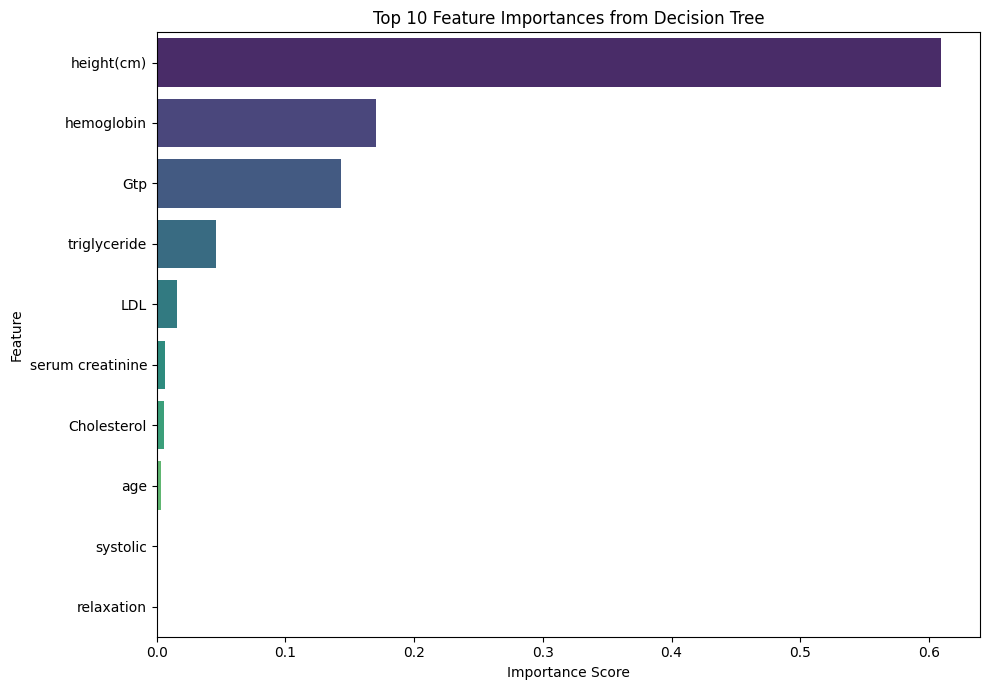

In [ ]:
if 'best_dt_classifier' in locals() and hasattr(best_dt_classifier, 'feature_importances_') and 'X_train_processed' in locals():
    print("\n--- Decision Tree: Feature Importances ---\n")
    importances_dt = best_dt_classifier.feature_importances_
    feature_names_dt = X_train_processed.columns

    feature_importance_df_dt = pd.DataFrame({'feature': feature_names_dt, 'importance': importances_dt})
    feature_importance_df_dt = feature_importance_df_dt.sort_values(by='importance', ascending=False)

    print("Top 10 most important features according to the Decision Tree:\n")
    print(feature_importance_df_dt.head(10))
    print("\n")

    plt.figure(figsize=(10, 7))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_dt.head(10), palette='viridis')
    plt.title('Top 10 Feature Importances from Decision Tree')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Decision Tree model ('best_dt_classifier') or 'X_train_processed' not found or model has no feature_importances_.")


--- Decision Tree: Visualizing Top Levels of the Tree ---



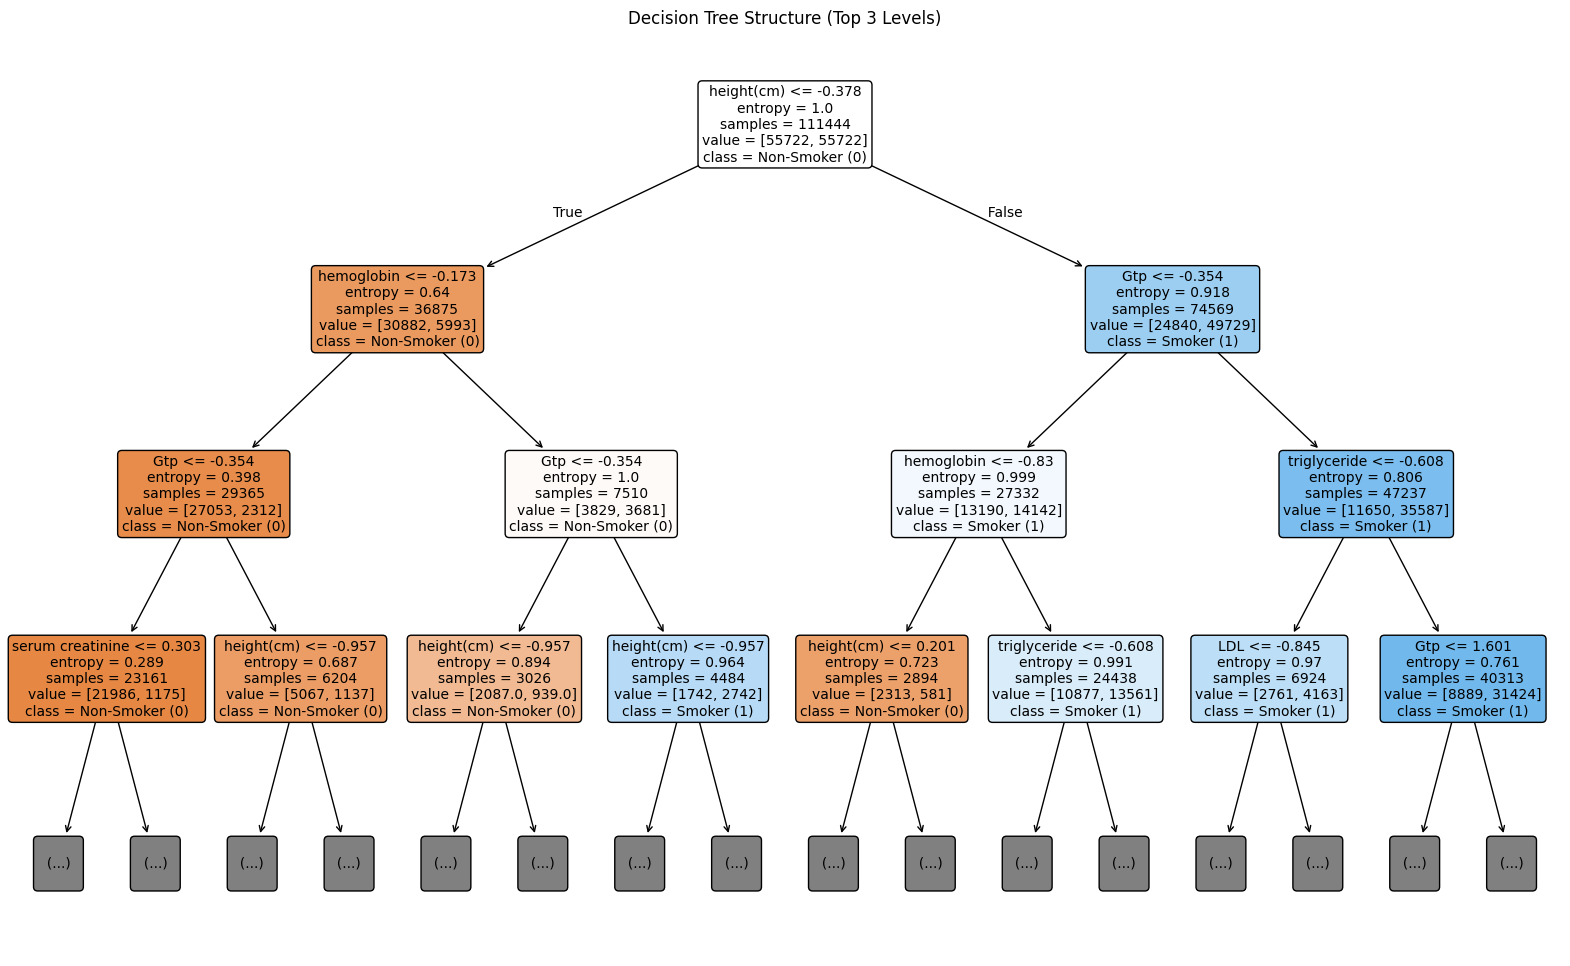


--- Decision Tree: Text Representation of Rules (Example for depth 3) ---

|--- height(cm) <= -0.38
|   |--- hemoglobin <= -0.17
|   |   |--- Gtp <= -0.35
|   |   |   |--- serum creatinine <= 0.30
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- serum creatinine >  0.30
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- Gtp >  -0.35
|   |   |   |--- height(cm) <= -0.96
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- height(cm) >  -0.96
|   |   |   |   |--- truncated branch of depth 2
|   |--- hemoglobin >  -0.17
|   |   |--- Gtp <= -0.35
|   |   |   |--- height(cm) <= -0.96
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- height(cm) >  -0.96
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- Gtp >  -0.35
|   |   |   |--- height(cm) <= -0.96
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- height(cm) >  -0.96
|   |   |   |   |--- truncated branch of depth 2
|--- height(cm) >  -0.38
|   |--- Gtp <

In [ ]:
if 'best_dt_classifier' in locals() and 'X_train_processed' in locals():
    print("\n--- Decision Tree: Visualizing Top Levels of the Tree ---\n")
    plt.figure(figsize=(20,12))
    plot_tree(best_dt_classifier,
              feature_names=list(X_train_processed.columns),
              class_names=['Non-Smoker (0)', 'Smoker (1)'],
              filled=True,
              rounded=True,
              impurity=True,
              proportion=False,
              fontsize=10,
              max_depth=3)
    plt.title("Decision Tree Structure (Top 3 Levels)")
    plt.show()

    print("\n--- Decision Tree: Text Representation of Rules (Example for depth 3) ---\n")
    try:
        tree_rules = export_text(best_dt_classifier,
                                 feature_names=list(X_train_processed.columns),
                                 max_depth=3)
        print(tree_rules)
    except Exception as e:
        print(f"Could not print tree rules: {e}")
else:
    print("Decision Tree model or X_train_processed not available for rule visualization.")

### 6.2. k-Nearest Neighbors (k-NN) Classifier


--- Tuning k-Nearest Neighbors ---

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best k-NN Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}

--- Training Best k-Nearest Neighbors ---

Best k-NN model trained! Training time: 0.08 seconds
Best k-NN model validated! Validation time: 30.34 seconds

--- Best k-NN Validation Metrics ---

Accuracy: 0.7669
Precision: 0.7284
Recall: 0.8511
F1-Score: 0.7850
ROC-AUC: 0.8340



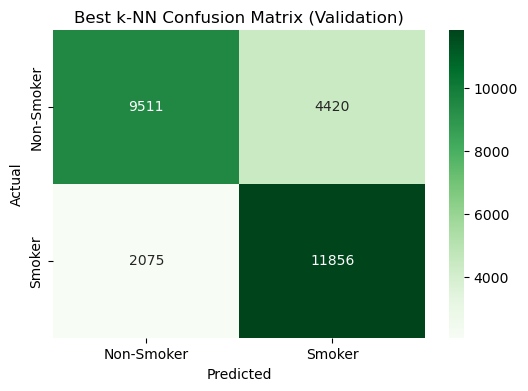

In [ ]:
if 'X_train_processed' in locals():

    # --- Hyperparameter Tuning for k-NN (using GridSearchCV) ---
    print("\n--- Tuning k-Nearest Neighbors ---\n")
    knn_param_grid = {
        'n_neighbors': [3, 7, 11, 15], # 3, 5, 7, 9, 11, 15
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'], # ['auto', 'ball_tree', 'kd_tree', 'brute']
        'p': [1, 2] # 1 for Manhattan, 2 for Euclidean
    }
    knn_grid_search = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

    # Uncomment the line below to run GridSearchCV
    knn_grid_search.fit(X_train_processed, y_train)
    print(f"Best k-NN Parameters: {knn_grid_search.best_params_}")
    best_knn_classifier = knn_grid_search.best_estimator_

    # best_knn_params = {'n_neighbors': 15, 'p': 2, 'weights': 'uniform', 'algorithm': 'ball_tree'}
    # best_knn_classifier = KNeighborsClassifier(**best_knn_params, n_jobs=-1)

    # Train the best k-NN model
    print("\n--- Training Best k-Nearest Neighbors ---\n")
    start_time_knn_train = time.time()
    best_knn_classifier.fit(X_train_processed, y_train)
    end_time_knn_train = time.time()
    training_time_knn = end_time_knn_train - start_time_knn_train
    training_times['k-NN'] = training_time_knn
    print(f"Best k-NN model trained! Training time: {training_time_knn:.2f} seconds")

    # Make predictions on the validation set
    start_time_knn_val = time.time()
    y_pred_knn = best_knn_classifier.predict(X_val_processed) # Corrected variable
    end_time_knn_val = time.time()
    validation_time_knn = end_time_knn_val - start_time_knn_val
    validation_times['k-NN'] = validation_time_knn
    print(f"Best k-NN model validated! Validation time: {validation_time_knn:.2f} seconds")

    # Evaluate the model
    accuracy_knn = accuracy_score(y_val, y_pred_knn)
    precision_knn = precision_score(y_val, y_pred_knn)
    recall_knn = recall_score(y_val, y_pred_knn)
    f1_knn = f1_score(y_val, y_pred_knn)
    roc_auc_knn = roc_auc_score(y_val, best_knn_classifier.predict_proba(X_val_processed)[:, 1])
    cm_knn = confusion_matrix(y_val, y_pred_knn)
    model_performance['k-NN'] = {'Accuracy': accuracy_knn, 'Precision': precision_knn, 'Recall': recall_knn, 'F1-Score': f1_knn, 'ROC-AUC': roc_auc_knn}

    print("\n--- Best k-NN Validation Metrics ---\n")
    print(f"Accuracy: {accuracy_knn:.4f}")
    print(f"Precision: {precision_knn:.4f}")
    print(f"Recall: {recall_knn:.4f}")
    print(f"F1-Score: {f1_knn:.4f}")
    print(f"ROC-AUC: {roc_auc_knn:.4f}\n")

    # Display the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
    plt.title('Best k-NN Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Processed training data not available for k-NN.")

#### k-NN: Feature Importance (Permutation Importance)


--- k-NN: Calculating Permutation Importance on Validation Set ---


Top 10 most important features for k-NN (Permutation Importance):

             feature  importance
1         height(cm)    0.033937
15        hemoglobin    0.032597
20               Gtp    0.027737
12      triglyceride    0.011366
14               LDL    0.008537
17  serum creatinine    0.006368
11       Cholesterol    0.004554
0                age    0.004489
13               HDL    0.003201
18               AST    0.003083


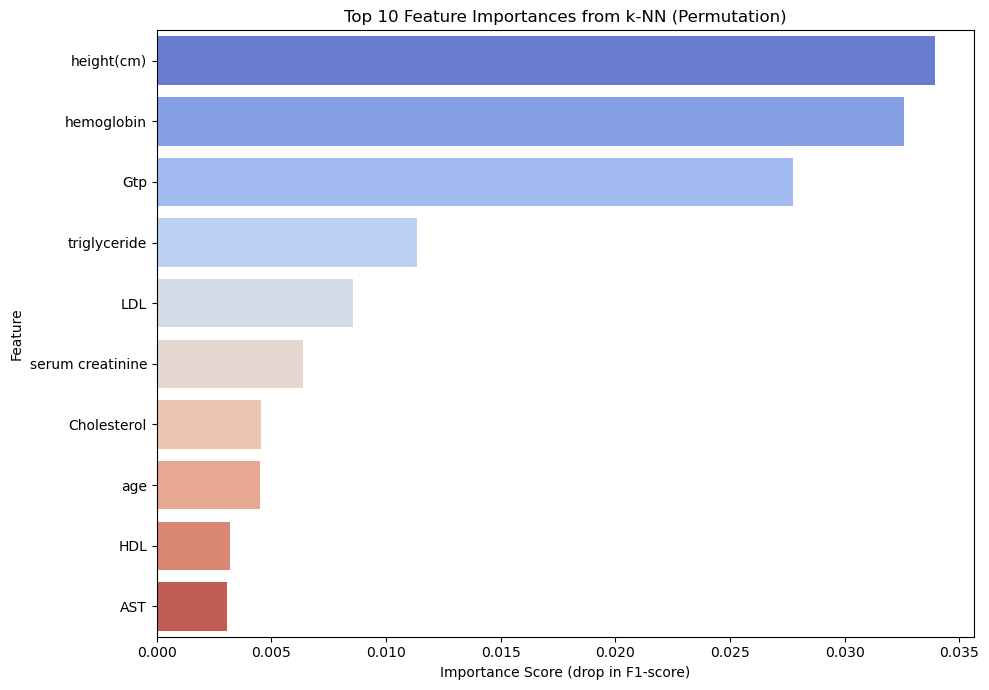

In [15]:
if 'best_knn_classifier' in locals() and 'X_val_processed' in locals() and 'y_val' in locals():
    print("\n--- k-NN: Calculating Permutation Importance on Validation Set ---\n")

    r_knn = permutation_importance(best_knn_classifier, X_val_processed, y_val,
                                    n_repeats=3,
                                    random_state=42,
                                    scoring='f1',
                                    n_jobs=-1)

    knn_importances_mean = r_knn.importances_mean
    feature_names_knn = X_val_processed.columns

    feature_importance_df_knn = pd.DataFrame({'feature': feature_names_knn, 'importance': knn_importances_mean})
    feature_importance_df_knn = feature_importance_df_knn.sort_values(by='importance', ascending=False)

    print("\nTop 10 most important features for k-NN (Permutation Importance):\n")
    print(feature_importance_df_knn.head(10))

    plt.figure(figsize=(10, 7))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_knn.head(10), palette='coolwarm')
    plt.title('Top 10 Feature Importances from k-NN (Permutation)')
    plt.xlabel('Importance Score (drop in F1-score)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("k-NN model or validation data not found for permutation importance.")

#### k-NN: Visualizing Decision Boundary (on 2 Key Features)

Using features for k-NN decision boundary: height(cm), hemoglobin



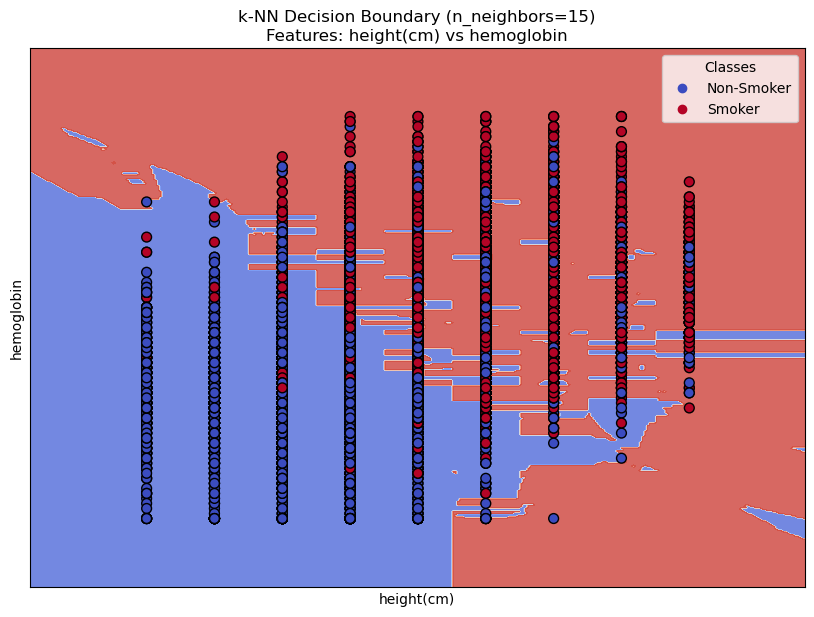

In [16]:
if 'best_knn_classifier' in locals() and 'X_train_processed' in locals():
    feature1_name = 'height(cm)'
    feature2_name = 'hemoglobin'

    print(f"Using features for k-NN decision boundary: {feature1_name}, {feature2_name}\n")

    if feature1_name in X_train_processed.columns and feature2_name in X_train_processed.columns:
        X_train_2_features = X_train_processed[[feature1_name, feature2_name]]
        X_val_2_features = X_val_processed[[feature1_name, feature2_name]]

        # Train a new k-NN model on these two features
        knn_2d = KNeighborsClassifier(n_neighbors=best_knn_classifier.n_neighbors,
                                      weights=best_knn_classifier.weights,
                                      p=best_knn_classifier.p,
                                      algorithm=best_knn_classifier.algorithm,
                                      n_jobs=-1)
        knn_2d.fit(X_train_2_features, y_train)

        # Create a mesh to plot in
        h = .02
        x_min, x_max = X_val_2_features[feature1_name].values.min() - 1, X_val_2_features[feature1_name].values.max() + 1
        y_min, y_max = X_val_2_features[feature2_name].values.min() - 1, X_val_2_features[feature2_name].values.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Plot the decision boundary
        Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(10, 7))
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # Plot the validation points
        scatter = plt.scatter(X_val_2_features[feature1_name], X_val_2_features[feature2_name],
                              c=y_val, cmap=plt.cm.coolwarm, edgecolors='k', s=50)
        plt.xlabel(feature1_name)
        plt.ylabel(feature2_name)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(f"k-NN Decision Boundary (n_neighbors={best_knn_classifier.n_neighbors})\nFeatures: {feature1_name} vs {feature2_name}")
        handles, labels = scatter.legend_elements()
        plt.legend(handles=handles, labels=['Non-Smoker', 'Smoker'], title="Classes")
        plt.show()

    else:
        print(f"Error: One or both manually selected features ('{feature1_name}', '{feature2_name}') not found in X_train_processed.columns.")
        print(f"Available columns: {list(X_train_processed.columns)}")
else:
    print("k-NN model ('best_knn_classifier') or 'X_train_processed' data not found for decision boundary plot.")

### 6.3. Support Vector Machine (SVM) Classifier


--- Tuning Support Vector Machine ---

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'C': 1.786429543354675, 'gamma': 0.0238687625248947, 'kernel': 'rbf'}

--- Training Best Support Vector Machine ---

Best SVM model trained! Training time: 1759.80 seconds
Best SVM model validated! Validation time: 62.80 seconds

--- Best SVM Validation Metrics ---

Accuracy: 0.7866
Precision: 0.7319
Recall: 0.9047
F1-Score: 0.8092
ROC-AUC: 0.8530



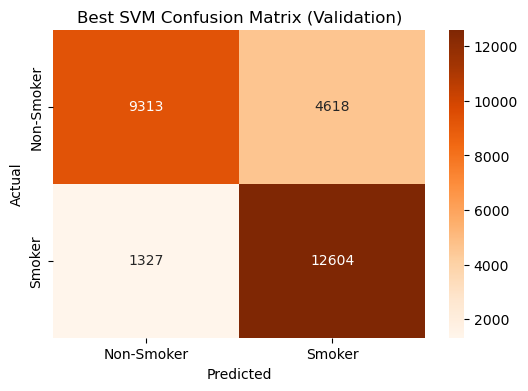

In [ ]:
if 'X_train_processed' in locals():

    # --- Hyperparameter Tuning for SVM (using GridSearchCV) ---
    print("\n--- Tuning Support Vector Machine ---\n")
    svm_param_dist = {
        'C': expon(scale=1),
        'gamma': expon(scale=0.1),
        'kernel': ['rbf'],
    }
    n_search_iter = 10

    random_search_svm = RandomizedSearchCV(
        SVC(probability=True, random_state=42, cache_size=1200),
        param_distributions=svm_param_dist,
        n_iter=n_search_iter,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    # Uncomment the line below to run GridSearchCV
    # random_search_svm.fit(X_train_processed, y_train)
    # print(f"Best SVM Parameters: {random_search_svm.best_params_}")
    # best_svm_classifier = random_search_svm.best_estimator_

    best_svm_params = {'C': 1.786429543354675, 'gamma': 0.0238687625248947, 'kernel': 'rbf'}
    best_svm_classifier = SVC(**best_svm_params, probability=True, random_state=42)

    # Train the best SVM model
    print("\n--- Training Best Support Vector Machine ---\n")
    start_time_svm_train = time.time()
    best_svm_classifier.fit(X_train_processed, y_train)
    end_time_svm_train = time.time()
    training_time_svm = end_time_svm_train - start_time_svm_train
    training_times['SVM'] = training_time_svm
    print(f"Best SVM model trained! Training time: {training_time_svm:.2f} seconds")

    # Make predictions on the validation set
    start_time_svm_val = time.time()
    y_pred_svm = best_svm_classifier.predict(X_val_processed)
    end_time_svm_val = time.time()
    validation_time_svm = end_time_svm_val - start_time_svm_val
    validation_times['SVM'] = validation_time_svm
    print(f"Best SVM model validated! Validation time: {validation_time_svm:.2f} seconds")

    # Evaluate the model
    accuracy_svm = accuracy_score(y_val, y_pred_svm)
    precision_svm = precision_score(y_val, y_pred_svm)
    recall_svm = recall_score(y_val, y_pred_svm)
    f1_svm = f1_score(y_val, y_pred_svm)
    roc_auc_svm = roc_auc_score(y_val, best_svm_classifier.predict_proba(X_val_processed)[:, 1])
    cm_svm = confusion_matrix(y_val, y_pred_svm)
    model_performance['SVM'] = {'Accuracy': accuracy_svm, 'Precision': precision_svm, 'Recall': recall_svm, 'F1-Score': f1_svm, 'ROC-AUC': roc_auc_svm}

    print("\n--- Best SVM Validation Metrics ---\n")
    print(f"Accuracy: {accuracy_svm:.4f}")
    print(f"Precision: {precision_svm:.4f}")
    print(f"Recall: {recall_svm:.4f}")
    print(f"F1-Score: {f1_svm:.4f}")
    print(f"ROC-AUC: {roc_auc_svm:.4f}\n")

    # Display the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
    plt.title('Best SVM Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Processed training data not available for SVM.")

#### SVM: Feature Importance (Permutation Importance)


--- SVM: Calculating Permutation Importance on Validation Set ---


Top 10 most important features for SVM (Permutation Importance):

             feature  importance
1         height(cm)    0.058469
15        hemoglobin    0.035987
20               Gtp    0.031414
14               LDL    0.014189
12      triglyceride    0.008681
17  serum creatinine    0.005463
0                age    0.004893
13               HDL    0.004798
2         weight(kg)    0.004417
19               ALT    0.003943


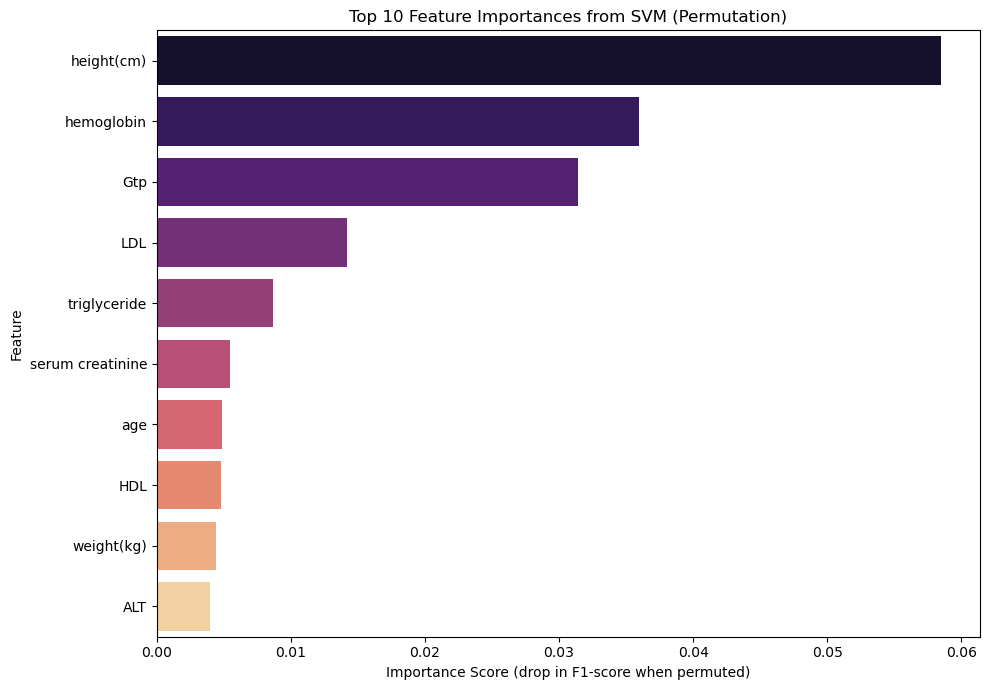

In [22]:
if 'best_svm_classifier' in locals() and 'X_val_processed' in locals():
    print("\n--- SVM: Calculating Permutation Importance on Validation Set ---\n")

    r_svm = permutation_importance(best_svm_classifier, X_val_processed, y_val,
                                    n_repeats=3,
                                    random_state=42,
                                    scoring='f1',
                                    n_jobs=-1)

    svm_importances_mean = r_svm.importances_mean
    feature_names_svm = X_val_processed.columns

    feature_importance_df_svm = pd.DataFrame({'feature': feature_names_svm, 'importance': svm_importances_mean})
    feature_importance_df_svm = feature_importance_df_svm.sort_values(by='importance', ascending=False)

    print("\nTop 10 most important features for SVM (Permutation Importance):\n")
    print(feature_importance_df_svm.head(10))

    plt.figure(figsize=(10, 7))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_svm.head(10), palette='magma')
    plt.title('Top 10 Feature Importances from SVM (Permutation)')
    plt.xlabel('Importance Score (drop in F1-score when permuted)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("SVM model ('best_svm_classifier') or validation data not found for permutation importance.")

#### SVM: Visualizing Decision Boundary (on 2 Key Features)

Using features for SVM decision boundary: height(cm), hemoglobin



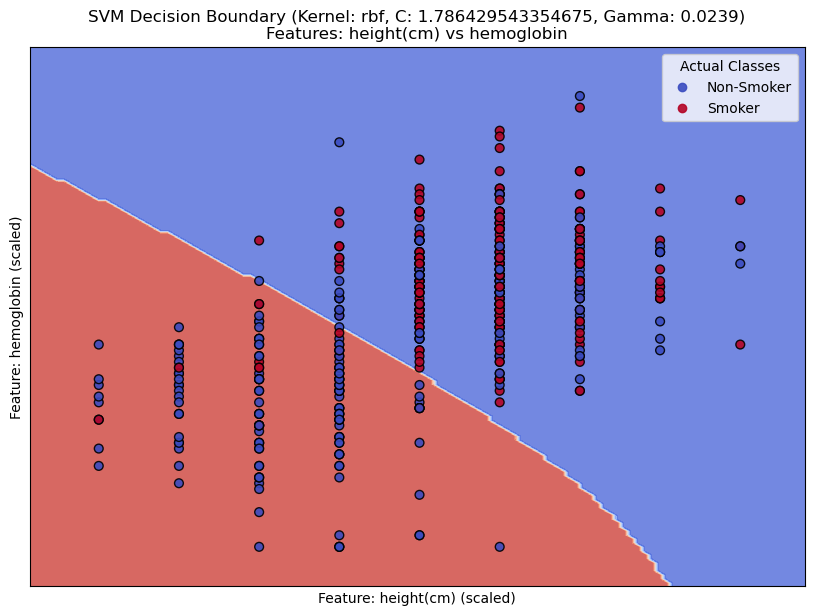

In [25]:
if 'best_svm_classifier' in locals() and 'X_train_processed' in locals() and 'y_train' in locals():
    feature1_name = 'height(cm)'
    feature2_name = 'hemoglobin'

    print(f"Using features for SVM decision boundary: {feature1_name}, {feature2_name}\n")

    if feature1_name in X_train_processed.columns and feature2_name in X_train_processed.columns:
        X_train_2_features_svm = X_train_processed[[feature1_name, feature2_name]]
        X_val_2_features_svm = X_val_processed[[feature1_name, feature2_name]]

        # Train a new SVM model only on these two features
        # Use the best hyperparameters (C, gamma, kernel) from your 'best_svm_classifier'
        svm_2d = SVC(C=best_svm_classifier.C,
                     gamma=best_svm_classifier.gamma,
                     kernel=best_svm_classifier.kernel,
                     random_state=42,
                     cache_size=getattr(best_svm_classifier, 'cache_size', 1200))

        svm_2d.fit(X_train_2_features_svm, y_train)

        # Create a mesh to plot in
        h = .05
        x_min, x_max = X_train_2_features_svm[feature1_name].min() - 0.5, X_train_2_features_svm[feature1_name].max() + 0.5
        y_min, y_max = X_train_2_features_svm[feature2_name].min() - 0.5, X_train_2_features_svm[feature2_name].max() + 0.5
        xx_svm, yy_svm = np.meshgrid(np.arange(x_min, x_max, h),
                                     np.arange(y_min, y_max, h))

        # Plot the decision boundary
        Z_svm = svm_2d.predict(np.c_[xx_svm.ravel(), yy_svm.ravel()])
        Z_svm = Z_svm.reshape(xx_svm.shape)

        plt.figure(figsize=(10, 7))
        plt.contourf(xx_svm, yy_svm, Z_svm, cmap=plt.cm.coolwarm_r, alpha=0.8)
        # Plot a sample of the validation points for clarity
        sample_val_indices_svm = np.random.choice(X_val_2_features_svm.index,
                                                  size=min(500, len(X_val_2_features_svm)),
                                                  replace=False)

        scatter_svm_val = plt.scatter(X_val_2_features_svm.loc[sample_val_indices_svm, feature1_name],
                                      X_val_2_features_svm.loc[sample_val_indices_svm, feature2_name],
                                      c=y_val.loc[sample_val_indices_svm], cmap=plt.cm.coolwarm,
                                      edgecolors='k', s=40, alpha=0.9)

        plt.xlabel(f"Feature: {feature1_name} (scaled)")
        plt.ylabel(f"Feature: {feature2_name} (scaled)")
        plt.xlim(xx_svm.min(), xx_svm.max())
        plt.ylim(yy_svm.min(), yy_svm.max())
        plt.xticks(())
        plt.yticks(())
        # Ensure kernel, C, and gamma values are accessible from your best_svm_classifier
        kernel_val = getattr(best_svm_classifier, 'kernel', 'N/A')
        C_val = getattr(best_svm_classifier, 'C', 'N/A')
        gamma_val = getattr(best_svm_classifier, 'gamma', 'N/A')
        if isinstance(gamma_val, float): gamma_val = f"{gamma_val:.4f}"

        plt.title(f"SVM Decision Boundary (Kernel: {kernel_val}, C: {C_val}, Gamma: {gamma_val})\nFeatures: {feature1_name} vs {feature2_name}")

        # Create legend
        handles_svm, labels_svm = scatter_svm_val.legend_elements()
        if len(labels_svm) == 1 and labels_svm[0] == '0':
             labels_svm_display = ['Non-Smoker']
        elif len(labels_svm) == 1 and labels_svm[0] == '1':
             labels_svm_display = ['Smoker']
        elif len(labels_svm) == 2 :
             labels_svm_display = ['Non-Smoker', 'Smoker']
        else:
             labels_svm_display = labels_svm

        plt.legend(handles=handles_svm, labels=labels_svm_display, title="Actual Classes")
        plt.show()
    else:
        print(f"Error: One or both selected features ('{feature1_name}', '{feature2_name}') not found in X_train_processed.columns.")
        print(f"Available columns: {list(X_train_processed.columns)}")

else:
    print("SVM model ('best_svm_classifier'), X_train_processed, or y_train not found for decision boundary plot.")

### 6.4. Neural Network (Multi-Layer Perceptron) Classifier


--- Defining and Training Neural Network (Original Version) ---

--- Neural Network (Original Version) Hyperparameters ---

layer_1_neurons: 64
layer_1_activation: relu
dropout_1_rate: 0.3
layer_2_neurons: 32
layer_2_activation: relu
dropout_2_rate: 0.2
output_layer_activation: sigmoid
optimizer: Adam
learning_rate: 0.001
loss_function: binary_crossentropy
epochs_trained_for: 15
batch_size: 32

-------------------------------------------------------


--- Model Summary (Original Version) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)


-------------------------------------

--- Training Neural Network (Original Version) for 15 epochs ---
Epoch 1/15
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 3s 796us/step - accuracy: 0.7408 - loss: 0.5137 - precision: 0.7069 - recall: 0.8205 - val_accuracy: 0.7770 - val_loss: 0.4612 - val_precision: 0.7309 - val_recall: 0.8770
Epoch 2/15
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 3s 739us/step - accuracy: 0.7719 - loss: 0.4717 - precision: 0.7301 - recall: 0.8627 - val_accuracy: 0.7816 - val_loss: 0.4597 - val_precision: 0.7307 - val_recall: 0.8919
Epoch 3/15
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 3s 779us/step - accuracy: 0.7752 - loss: 0.4667 - precision: 0.7350 - recall: 0.8637 - val_accuracy: 0.7820 - val_loss: 0.4553 - val_precision: 0.7399 - val_recall: 0.8696
Epoch 4/15
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 3s 740us/step - accuracy: 0.7765 - loss: 0.4664 - precision: 0.7372 - recall: 0.8622 - val_accuracy: 0.7818 - val_loss: 0.4585 - val_precision: 0.7398 - val_recall: 0.8694
Epoch 5/15
3483/3483 ━━━━━━━━━━━━━━━━━━

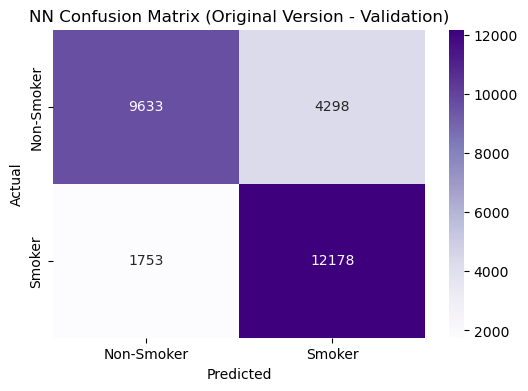


--- Training History (Original Version) ---



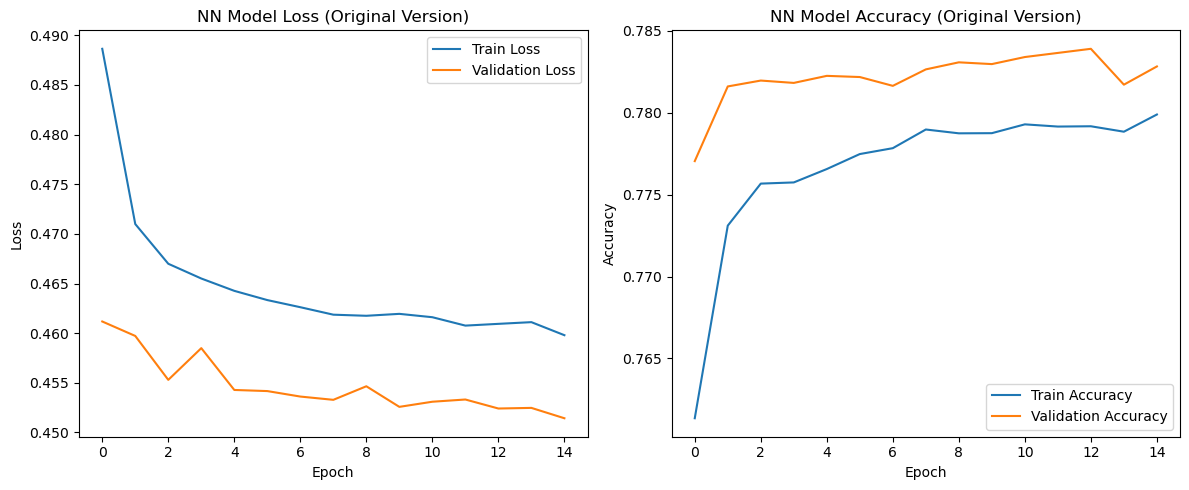

In [26]:
if 'X_train_processed' in locals():

    print("\n--- Defining and Training Neural Network (Original Version) ---\n")
    # --- Define Hyperparameters for this version ---
    nn_params_original = {
        'layer_1_neurons': 64,
        'layer_1_activation': 'relu',
        'dropout_1_rate': 0.3,
        'layer_2_neurons': 32,
        'layer_2_activation': 'relu',
        'dropout_2_rate': 0.2,
        'output_layer_activation': 'sigmoid',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'loss_function': 'binary_crossentropy',
        'epochs_trained_for': 15,
        'batch_size': 32
    }

    print("--- Neural Network (Original Version) Hyperparameters ---\n")
    for param, value in nn_params_original.items():
        print(f"{param}: {value}")
    print("\n-------------------------------------------------------\n")

    # Define the Neural Network model
    nn_model_original = keras.Sequential([
        layers.Dense(nn_params_original['layer_1_neurons'], activation=nn_params_original['layer_1_activation'],
                     input_shape=(X_train_processed.shape[1],)),
        layers.Dropout(nn_params_original['dropout_1_rate']),
        layers.Dense(nn_params_original['layer_2_neurons'], activation=nn_params_original['layer_2_activation']),
        layers.Dropout(nn_params_original['dropout_2_rate']),
        layers.Dense(1, activation=nn_params_original['output_layer_activation'])
    ])

    # Compile the model
    nn_model_original.compile(optimizer=keras.optimizers.Adam(learning_rate=nn_params_original['learning_rate']),
                              loss=nn_params_original['loss_function'],
                              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

    print("\n--- Model Summary (Original Version) ---")
    nn_model_original.summary()
    print("\n-------------------------------------\n")

    # Train the model
    epochs = nn_params_original['epochs_trained_for']
    batch_size = nn_params_original['batch_size']

    print(f"--- Training Neural Network (Original Version) for {epochs} epochs ---")
    start_time_nn_train = time.time()
    history_original = nn_model_original.fit(X_train_processed, y_train,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            validation_data=(X_val_processed, y_val),
                                            verbose=1)
    end_time_nn_train = time.time()
    training_time_nn_original = end_time_nn_train - start_time_nn_train

    # Use a distinct key for this version in your results dictionaries
    if 'training_times' not in globals(): training_times = {}
    training_times['Neural Network (Original)'] = training_time_nn_original
    print(f"\nNeural Network (Original Version) model trained! Training time: {training_time_nn_original:.2f} seconds")

    # Make predictions (probabilities)
    start_time_nn_val = time.time()
    y_pred_proba_nn_original = nn_model_original.predict(X_val_processed)
    y_pred_nn_original = (y_pred_proba_nn_original > 0.5).astype(int).flatten()
    end_time_nn_val = time.time()
    validation_time_nn_original = end_time_nn_val - start_time_nn_val
    if 'validation_times' not in globals(): validation_times = {}
    validation_times['Neural Network (Original)'] = validation_time_nn_original
    print(f"\nNeural Network (Original Version) model validated! Validation time: {validation_time_nn_original:.2f} seconds")

    # Evaluate the model
    accuracy_nn_original = accuracy_score(y_val, y_pred_nn_original)
    precision_nn_original = precision_score(y_val, y_pred_nn_original)
    recall_nn_original = recall_score(y_val, y_pred_nn_original)
    f1_nn_original = f1_score(y_val, y_pred_nn_original)
    roc_auc_nn_original = roc_auc_score(y_val, y_pred_proba_nn_original)
    cm_nn_original = confusion_matrix(y_val, y_pred_nn_original)

    if 'model_performance' not in globals(): model_performance = {}
    model_performance['Neural Network (Original)'] = {
        'Accuracy': accuracy_nn_original, 'Precision': precision_nn_original,
        'Recall': recall_nn_original, 'F1-Score': f1_nn_original, 'ROC-AUC': roc_auc_nn_original
    }

    print("\n--- Neural Network (Original Version) Validation Metrics ---\n")
    print(f"Accuracy: {accuracy_nn_original:.4f}")
    print(f"Precision: {precision_nn_original:.4f}")
    print(f"Recall: {recall_nn_original:.4f}")
    print(f"F1-Score: {f1_nn_original:.4f}")
    print(f"ROC-AUC: {roc_auc_nn_original:.4f}\n")

    # Display the confusion matrix
    print("\n--- Confusion Matrix (Original Version) ---\n")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_nn_original, annot=True, fmt='d', cmap='Purples',
                xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
    plt.title('NN Confusion Matrix (Original Version - Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\n--- Training History (Original Version) ---\n")
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_original.history['loss'], label='Train Loss')
    plt.plot(history_original.history['val_loss'], label='Validation Loss')
    plt.title('NN Model Loss (Original Version)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history_original.history['accuracy'], label='Train Accuracy')
    plt.plot(history_original.history['val_accuracy'], label='Validation Accuracy')
    plt.title('NN Model Accuracy (Original Version)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

else:
    print("Processed training data not available for Neural Network.")


--- Defining and Training Enhanced Neural Network ---



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,209 (55.50 KB)

 Trainable params: 13,761 (53.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7197 - loss: 0.6981 - precision: 0.6960 - recall: 0.7795 - val_accuracy: 0.7774 - val_loss: 0.5587 - val_precision: 0.7368 - val_recall: 0.8631 - learning_rate: 5.0000e-04
Epoch 2/100
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7664 - loss: 0.5653 - precision: 0.7277 - recall: 0.8543 - val_accuracy: 0.7803 - val_loss: 0.5071 - val_precision: 0.7327 - val_recall: 0.8826 - learning_rate: 5.0000e-04
Epoch 3/100
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7664 - loss: 0.5202 - precision: 0.7233 - recall: 0.8540 - val_accuracy: 0.7794 - val_loss: 0.4833 - val_precision: 0.7409 - val_recall: 0.8593 - learning_rate: 5.0000e-04
Epoch 4/100
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7713 - loss: 0.4929 - precision: 0.7319 - recall: 0.8550 - val_accuracy: 0.7803 - val_loss: 0.4731 - val_precision: 0.7314 - val_recall: 0.8861 - learning_rate: 5.0000e-04
Epoch 5/100
1742/1742 ━━━━━━━━━━━━━━

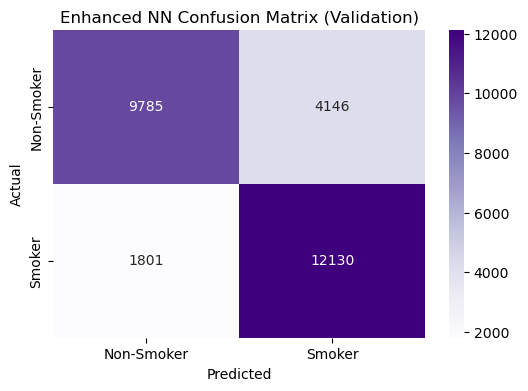


--- Training History (Enhanced Version) ---



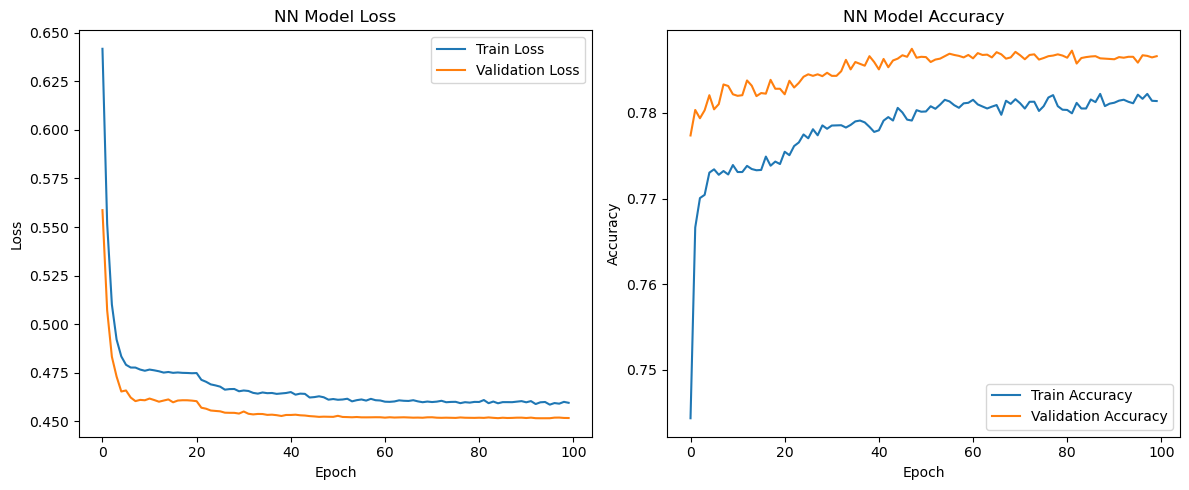

In [32]:
if 'X_train_processed' in locals():
    print("\n--- Defining and Training Enhanced Neural Network ---\n")
    # Define a potentially stronger Neural Network model
    nn_model_enhanced = keras.Sequential([
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train_processed.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    nn_model_enhanced.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

    nn_model_enhanced.summary()

    # Train the model
    epochs = 100
    batch_size = 64

    start_time_nn_train = time.time()
    history = nn_model_enhanced.fit(X_train_processed, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_processed, y_val),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)
    end_time_nn_train = time.time()
    training_time_nn = end_time_nn_train - start_time_nn_train
    if 'training_times' not in globals(): training_times = {}
    training_times['Neural Network_Enhanced'] = training_time_nn
    print(f"\nEnhanced Neural Network model trained! Training time: {training_time_nn:.2f} seconds")

    # Make predictions
    start_time_nn_val = time.time()
    y_pred_proba_nn = nn_model_enhanced.predict(X_val_processed)
    y_pred_nn = (y_pred_proba_nn > 0.5).astype(int).flatten()
    end_time_nn_val = time.time()
    validation_time_nn = end_time_nn_val - start_time_nn_val
    if 'validation_times' not in globals(): validation_times = {}
    validation_times['Neural Network_Enhanced'] = validation_time_nn
    print(f"\nEnhanced Neural Network model validated! Validation time: {validation_time_nn:.2f} seconds")

    # Evaluate the model
    accuracy_nn = accuracy_score(y_val, y_pred_nn)
    precision_nn = precision_score(y_val, y_pred_nn)
    recall_nn = recall_score(y_val, y_pred_nn)
    f1_nn = f1_score(y_val, y_pred_nn)
    roc_auc_nn = roc_auc_score(y_val, y_pred_proba_nn)
    cm_nn = confusion_matrix(y_val, y_pred_nn)
    if 'model_performance' not in globals(): model_performance = {}
    model_performance['Neural Network_Enhanced'] = {
        'Accuracy': accuracy_nn, 'Precision': precision_nn,
        'Recall': recall_nn, 'F1-Score': f1_nn, 'ROC-AUC': roc_auc_nn
    }

    print("\n--- Enhanced Neural Network Validation Metrics ---\n")
    print(f"Accuracy: {accuracy_nn:.4f}")
    print(f"Precision: {precision_nn:.4f}")
    print(f"Recall: {recall_nn:.4f}")
    print(f"F1-Score: {f1_nn:.4f}")
    print(f"ROC-AUC: {roc_auc_nn:.4f}\n")

    # Display the confusion matrix
    print("\n--- Confusion Matrix (Enhanced Version) ---\n")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples',
                xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
    plt.title('Enhanced NN Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot training history
    print("\n--- Training History (Enhanced Version) ---\n")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('NN Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('NN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

else:
    print("Processed training data not available for Neural Network.")

#### Neural Network (Original): Feature Importance using SHAP


--- Neural Network (Original): Calculating SHAP values ---

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|                                                   | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


  1%|▍                                          | 1/100 [00:02<04:07,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


  2%|▊                                          | 2/100 [00:05<04:06,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step


  3%|█▎                                         | 3/100 [00:07<04:00,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 261us/step


  4%|█▋                                         | 4/100 [00:09<03:56,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step


  5%|██▏                                        | 5/100 [00:12<03:53,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step


  6%|██▌                                        | 6/100 [00:14<03:50,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step


  7%|███                                        | 7/100 [00:17<03:47,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step


  8%|███▍                                       | 8/100 [00:19<03:45,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step


  9%|███▊                                       | 9/100 [00:22<03:43,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step


 10%|████▏                                     | 10/100 [00:24<03:40,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step


 11%|████▌                                     | 11/100 [00:27<03:38,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 263us/step


 12%|█████                                     | 12/100 [00:29<03:34,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step


 13%|█████▍                                    | 13/100 [00:31<03:34,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step


 14%|█████▉                                    | 14/100 [00:34<03:31,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 15%|██████▎                                   | 15/100 [00:37<03:31,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 262us/step


 16%|██████▋                                   | 16/100 [00:39<03:28,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step


 17%|███████▏                                  | 17/100 [00:41<03:25,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step


 18%|███████▌                                  | 18/100 [00:44<03:23,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


 19%|███████▉                                  | 19/100 [00:46<03:22,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 261us/step


 20%|████████▍                                 | 20/100 [00:49<03:17,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step


 21%|████████▊                                 | 21/100 [00:51<03:15,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 256us/step


 22%|█████████▏                                | 22/100 [00:54<03:12,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 262us/step


 23%|█████████▋                                | 23/100 [00:56<03:10,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 261us/step


 24%|██████████                                | 24/100 [00:59<03:07,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step


 25%|██████████▌                               | 25/100 [01:01<03:05,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 26%|██████████▉                               | 26/100 [01:04<03:04,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 265us/step


 27%|███████████▎                              | 27/100 [01:06<03:02,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 265us/step


 28%|███████████▊                              | 28/100 [01:09<02:59,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 268us/step


 29%|████████████▏                             | 29/100 [01:11<02:56,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 261us/step


 30%|████████████▌                             | 30/100 [01:14<02:53,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step


 31%|█████████████                             | 31/100 [01:16<02:54,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 264us/step


 32%|█████████████▍                            | 32/100 [01:19<02:51,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 264us/step


 33%|█████████████▊                            | 33/100 [01:21<02:47,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 263us/step


 34%|██████████████▎                           | 34/100 [01:24<02:44,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 261us/step


 35%|██████████████▋                           | 35/100 [01:26<02:41,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step


 36%|███████████████                           | 36/100 [01:29<02:39,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step


 37%|███████████████▌                          | 37/100 [01:31<02:37,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 264us/step


 38%|███████████████▉                          | 38/100 [01:34<02:34,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 264us/step


 39%|████████████████▍                         | 39/100 [01:36<02:31,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step


 40%|████████████████▊                         | 40/100 [01:39<02:28,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step


 41%|█████████████████▏                        | 41/100 [01:41<02:26,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step


 42%|█████████████████▋                        | 42/100 [01:44<02:24,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 262us/step


 43%|██████████████████                        | 43/100 [01:46<02:21,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


 44%|██████████████████▍                       | 44/100 [01:49<02:21,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 268us/step


 45%|██████████████████▉                       | 45/100 [01:51<02:17,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step


 46%|███████████████████▎                      | 46/100 [01:54<02:15,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 270us/step


 47%|███████████████████▋                      | 47/100 [01:56<02:14,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step


 48%|████████████████████▏                     | 48/100 [01:59<02:11,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 267us/step


 49%|████████████████████▌                     | 49/100 [02:01<02:08,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step


 50%|█████████████████████                     | 50/100 [02:04<02:06,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 267us/step


 51%|█████████████████████▍                    | 51/100 [02:06<02:03,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step


 52%|█████████████████████▊                    | 52/100 [02:09<02:00,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 267us/step


 53%|██████████████████████▎                   | 53/100 [02:11<01:58,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 254us/step


 54%|██████████████████████▋                   | 54/100 [02:14<01:54,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step


 55%|███████████████████████                   | 55/100 [02:16<01:51,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 246us/step


 56%|███████████████████████▌                  | 56/100 [02:19<01:47,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step


 57%|███████████████████████▉                  | 57/100 [02:21<01:44,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step


 58%|████████████████████████▎                 | 58/100 [02:23<01:41,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 251us/step


 59%|████████████████████████▊                 | 59/100 [02:26<01:37,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step


 60%|█████████████████████████▏                | 60/100 [02:28<01:35,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step


 61%|█████████████████████████▌                | 61/100 [02:31<01:32,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 248us/step


 62%|██████████████████████████                | 62/100 [02:33<01:31,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step


 63%|██████████████████████████▍               | 63/100 [02:35<01:28,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step


 64%|██████████████████████████▉               | 64/100 [02:38<01:25,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 246us/step


 65%|███████████████████████████▎              | 65/100 [02:40<01:23,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step


 66%|███████████████████████████▋              | 66/100 [02:42<01:21,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step


 67%|████████████████████████████▏             | 67/100 [02:45<01:18,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step


 68%|████████████████████████████▌             | 68/100 [02:47<01:16,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 254us/step


 69%|████████████████████████████▉             | 69/100 [02:50<01:13,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 246us/step


 70%|█████████████████████████████▍            | 70/100 [02:52<01:11,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step


 71%|█████████████████████████████▊            | 71/100 [02:54<01:08,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step


 72%|██████████████████████████████▏           | 72/100 [02:57<01:06,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step


 73%|██████████████████████████████▋           | 73/100 [02:59<01:04,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step


 74%|███████████████████████████████           | 74/100 [03:01<01:01,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step


 75%|███████████████████████████████▌          | 75/100 [03:04<00:59,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 245us/step


 76%|███████████████████████████████▉          | 76/100 [03:06<00:57,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 251us/step


 77%|████████████████████████████████▎         | 77/100 [03:09<00:54,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step


 78%|████████████████████████████████▊         | 78/100 [03:11<00:52,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 268us/step


 79%|█████████████████████████████████▏        | 79/100 [03:14<00:50,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 245us/step


 80%|█████████████████████████████████▌        | 80/100 [03:16<00:48,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step


 81%|██████████████████████████████████        | 81/100 [03:18<00:45,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step


 82%|██████████████████████████████████▍       | 82/100 [03:21<00:43,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step


 83%|██████████████████████████████████▊       | 83/100 [03:23<00:40,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step


 84%|███████████████████████████████████▎      | 84/100 [03:26<00:38,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 263us/step


 85%|███████████████████████████████████▋      | 85/100 [03:28<00:36,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 248us/step


 86%|████████████████████████████████████      | 86/100 [03:30<00:33,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step


 87%|████████████████████████████████████▌     | 87/100 [03:33<00:31,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step


 88%|████████████████████████████████████▉     | 88/100 [03:35<00:28,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step


 89%|█████████████████████████████████████▍    | 89/100 [03:38<00:26,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step


 90%|█████████████████████████████████████▊    | 90/100 [03:40<00:23,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step


 91%|██████████████████████████████████████▏   | 91/100 [03:42<00:21,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step


 92%|██████████████████████████████████████▋   | 92/100 [03:45<00:19,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step


 93%|███████████████████████████████████████   | 93/100 [03:47<00:16,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step


 94%|███████████████████████████████████████▍  | 94/100 [03:50<00:14,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step


 95%|███████████████████████████████████████▉  | 95/100 [03:52<00:12,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 249us/step


 96%|████████████████████████████████████████▎ | 96/100 [03:54<00:09,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 264us/step


 97%|████████████████████████████████████████▋ | 97/100 [03:57<00:07,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 254us/step


 98%|█████████████████████████████████████████▏| 98/100 [03:59<00:04,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 250us/step


 99%|█████████████████████████████████████████▌| 99/100 [04:02<00:02,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step


100%|█████████████████████████████████████████| 100/100 [04:04<00:00,  2.44s/it]


<nOriginal shape of shap_values_nn: (100, 22, 1)<n
Processed shape of shap_values_nn: (100, 22)

SHAP values processed. Generating summary plot...



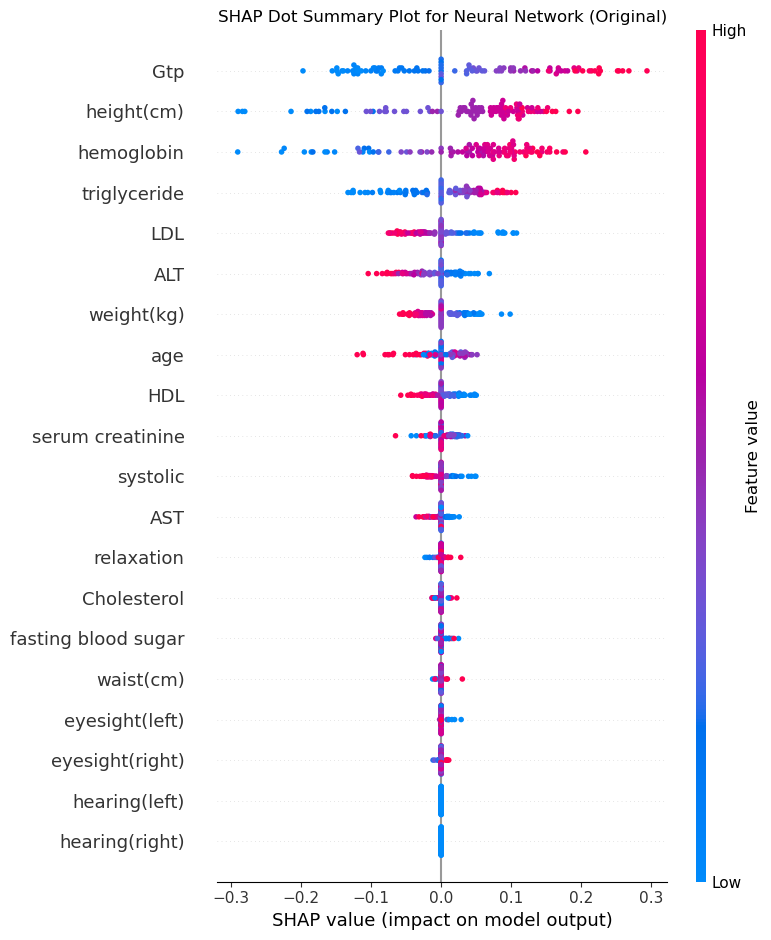


Generating SHAP bar plot with processed values...



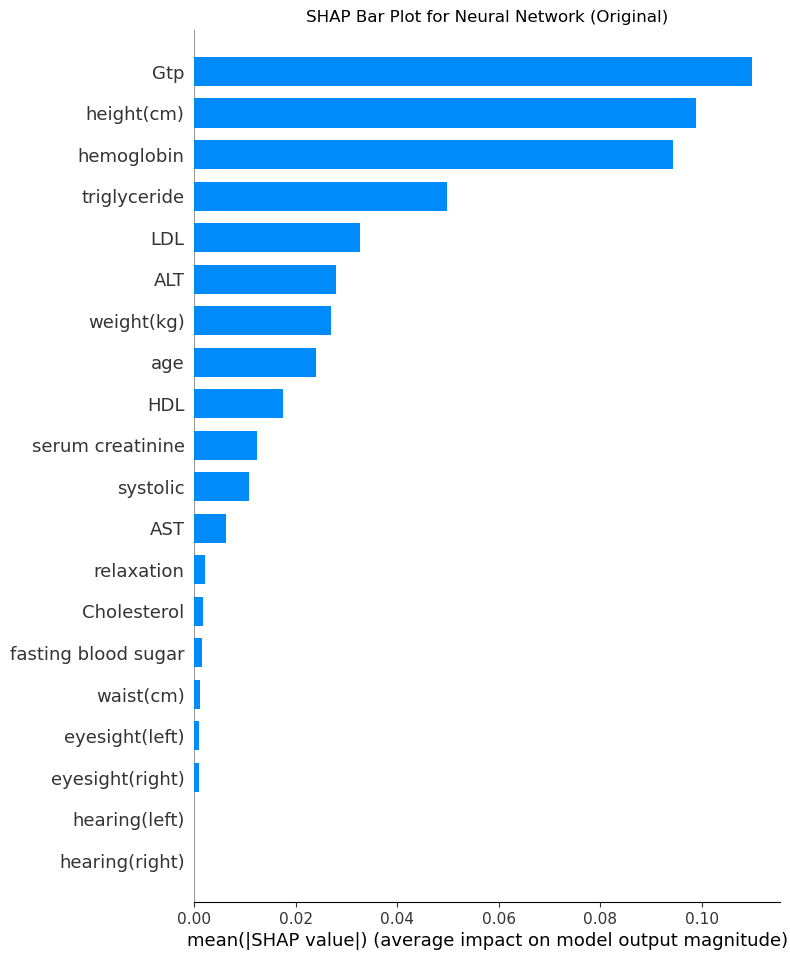

In [31]:
current_nn_model_to_explain = nn_model_original
model_name_for_plot = "Neural Network (Original)"

if 'current_nn_model_to_explain' in locals() and 'X_train_processed' in locals() and 'X_val_processed' in locals():
    print(f"\n--- {model_name_for_plot}: Calculating SHAP values ---\n")

    # SHAP requires a background dataset to integrate over.
    # A subset of the training data is used.
    background_data = shap.sample(X_train_processed, 100)
    explainer_nn = shap.KernelExplainer(current_nn_model_to_explain.predict, background_data)

    X_val_sample_for_shap = X_val_processed.sample(100, random_state=42) if len(X_val_processed) > 100 else X_val_processed

    shap_values_nn = explainer_nn.shap_values(X_val_sample_for_shap)

    print(f"<nOriginal shape of shap_values_nn: {shap_values_nn.shape}<n")

    # ---- THE FIX: Squeeze or reshape the shap_values_nn array ----
    if shap_values_nn.ndim == 3 and shap_values_nn.shape[-1] == 1:
        shap_values_nn_processed = shap_values_nn.squeeze(axis=-1)
        # Alternatively: shap_values_nn_processed = shap_values_nn[:, :, 0]
        print(f"Processed shape of shap_values_nn: {shap_values_nn_processed.shape}")
    else:
        # This case handles if shap_values_nn is already 2D or if it's a list (for multi-class)
        shap_values_nn_processed = shap_values_nn


    print("\nSHAP values processed. Generating summary plot...\n")

    if isinstance(shap_values_nn_processed, list):
        if len(shap_values_nn_processed) == 2 and shap_values_nn_processed[0].ndim == 2 :
             print("Plotting SHAP values for the positive class (class 1)")
             shap.summary_plot(shap_values_nn_processed[1], X_val_sample_for_shap,
                               feature_names=X_val_sample_for_shap.columns,
                               show=False, plot_type="dot")
        else:
             print("SHAP values are a list, plotting for the first element/class as example.")
             shap.summary_plot(shap_values_nn_processed[0], X_val_sample_for_shap,
                               feature_names=X_val_sample_for_shap.columns,
                               show=False, plot_type="dot")
    elif shap_values_nn_processed.ndim == 2:
        shap.summary_plot(shap_values_nn_processed, X_val_sample_for_shap,
                          feature_names=X_val_sample_for_shap.columns,
                          show=False, plot_type="dot")
    else:
        print(f"Error: Processed SHAP values have an unexpected shape: {shap_values_nn_processed.shape}")

    plt.title(f'SHAP Dot Summary Plot for {model_name_for_plot}')
    plt.tight_layout()
    plt.show()

    print("\nGenerating SHAP bar plot with processed values...\n")
    if isinstance(shap_values_nn_processed, list):
        if len(shap_values_nn_processed) == 2 and shap_values_nn_processed[0].ndim == 2:
            shap.summary_plot(shap_values_nn_processed[1], X_val_sample_for_shap, feature_names=X_val_sample_for_shap.columns, plot_type="bar", show=False)
        else:
            shap.summary_plot(shap_values_nn_processed[0], X_val_sample_for_shap, feature_names=X_val_sample_for_shap.columns, plot_type="bar", show=False)

    elif shap_values_nn_processed.ndim == 2:
        shap.summary_plot(shap_values_nn_processed, X_val_sample_for_shap, feature_names=X_val_sample_for_shap.columns, plot_type="bar", show=False)
    else:
        print("Cannot generate bar plot due to SHAP values shape.")

    plt.title(f'SHAP Bar Plot for {model_name_for_plot}')
    plt.show()

else:
    print("Neural Network model, X_train_processed, or X_val_processed not found for SHAP analysis.")
    print("Make sure to define 'current_nn_model_to_explain' and 'model_name_for_plot' before this cell.")

#### Neural Network (Enhanced): Feature Importance using SHAP


--- Neural Network (Enhanced): Calculating SHAP values ---

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|                                                   | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


  1%|▍                                          | 1/100 [00:02<04:49,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step


  2%|▊                                          | 2/100 [00:05<04:54,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step


  3%|█▎                                         | 3/100 [00:09<04:52,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 352us/step


  4%|█▋                                         | 4/100 [00:12<04:51,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 318us/step


  5%|██▏                                        | 5/100 [00:14<04:42,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step


  6%|██▌                                        | 6/100 [00:17<04:39,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step


  7%|███                                        | 7/100 [00:20<04:35,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 321us/step


  8%|███▍                                       | 8/100 [00:23<04:29,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 324us/step


  9%|███▊                                       | 9/100 [00:26<04:25,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 339us/step


 10%|████▏                                     | 10/100 [00:29<04:23,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 314us/step


 11%|████▌                                     | 11/100 [00:32<04:17,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 318us/step


 12%|█████                                     | 12/100 [00:35<04:12,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step


 13%|█████▍                                    | 13/100 [00:38<04:18,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step


 14%|█████▉                                    | 14/100 [00:41<04:16,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 371us/step


 15%|██████▎                                   | 15/100 [00:44<04:19,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 358us/step


 16%|██████▋                                   | 16/100 [00:47<04:19,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step


 17%|███████▏                                  | 17/100 [00:50<04:17,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 347us/step


 18%|███████▌                                  | 18/100 [00:54<04:19,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step


 19%|███████▉                                  | 19/100 [00:57<04:16,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 357us/step


 20%|████████▍                                 | 20/100 [01:00<04:13,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 375us/step


 21%|████████▊                                 | 21/100 [01:03<04:12,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 354us/step


 22%|█████████▏                                | 22/100 [01:06<04:08,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 369us/step


 23%|█████████▋                                | 23/100 [01:10<04:07,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step


 24%|██████████                                | 24/100 [01:13<04:02,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step


 25%|██████████▌                               | 25/100 [01:16<03:58,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 335us/step


 26%|██████████▉                               | 26/100 [01:19<03:54,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 351us/step


 27%|███████████▎                              | 27/100 [01:22<03:50,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step


 28%|███████████▊                              | 28/100 [01:26<03:49,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 365us/step


 29%|████████████▏                             | 29/100 [01:29<03:48,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step


 30%|████████████▌                             | 30/100 [01:32<03:49,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 345us/step


 31%|█████████████                             | 31/100 [01:35<03:41,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 335us/step


 32%|█████████████▍                            | 32/100 [01:38<03:35,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 353us/step


 33%|█████████████▊                            | 33/100 [01:42<03:31,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 321us/step


 34%|██████████████▎                           | 34/100 [01:44<03:22,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 338us/step


 35%|██████████████▋                           | 35/100 [01:47<03:17,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 325us/step


 36%|███████████████                           | 36/100 [01:50<03:14,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 324us/step


 37%|███████████████▌                          | 37/100 [01:53<03:08,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step


 38%|███████████████▉                          | 38/100 [01:56<03:04,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 327us/step


 39%|████████████████▍                         | 39/100 [01:59<02:59,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 337us/step


 40%|████████████████▊                         | 40/100 [02:02<02:57,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 336us/step


 41%|█████████████████▏                        | 41/100 [02:05<02:53,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 330us/step


 42%|█████████████████▋                        | 42/100 [02:08<02:50,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step


 43%|██████████████████                        | 43/100 [02:11<02:47,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 335us/step


 44%|██████████████████▍                       | 44/100 [02:14<02:45,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 329us/step


 45%|██████████████████▉                       | 45/100 [02:17<02:41,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 337us/step


 46%|███████████████████▎                      | 46/100 [02:20<02:39,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step


 47%|███████████████████▋                      | 47/100 [02:23<02:36,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 327us/step


 48%|████████████████████▏                     | 48/100 [02:26<02:32,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 338us/step


 49%|████████████████████▌                     | 49/100 [02:29<02:30,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 338us/step


 50%|█████████████████████                     | 50/100 [02:32<02:27,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 335us/step


 51%|█████████████████████▍                    | 51/100 [02:35<02:24,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 331us/step


 52%|█████████████████████▊                    | 52/100 [02:37<02:21,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step


 53%|██████████████████████▎                   | 53/100 [02:41<02:20,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 337us/step


 54%|██████████████████████▋                   | 54/100 [02:44<02:17,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


 55%|███████████████████████                   | 55/100 [02:47<02:14,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step


 56%|███████████████████████▌                  | 56/100 [02:49<02:10,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 334us/step


 57%|███████████████████████▉                  | 57/100 [02:52<02:07,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step


 58%|████████████████████████▎                 | 58/100 [02:55<02:05,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 337us/step


 59%|████████████████████████▊                 | 59/100 [02:58<02:02,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step


 60%|█████████████████████████▏                | 60/100 [03:01<01:59,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step


 61%|█████████████████████████▌                | 61/100 [03:04<01:55,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 338us/step


 62%|██████████████████████████                | 62/100 [03:07<01:52,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 345us/step


 63%|██████████████████████████▍               | 63/100 [03:10<01:50,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 339us/step


 64%|██████████████████████████▉               | 64/100 [03:13<01:47,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 338us/step


 65%|███████████████████████████▎              | 65/100 [03:16<01:44,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step


 66%|███████████████████████████▋              | 66/100 [03:19<01:41,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 323us/step


 67%|████████████████████████████▏             | 67/100 [03:22<01:38,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step


 68%|████████████████████████████▌             | 68/100 [03:25<01:34,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 319us/step


 69%|████████████████████████████▉             | 69/100 [03:28<01:32,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 339us/step


 70%|█████████████████████████████▍            | 70/100 [03:31<01:29,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


 71%|█████████████████████████████▊            | 71/100 [03:34<01:26,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 338us/step


 72%|██████████████████████████████▏           | 72/100 [03:37<01:23,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step


 73%|██████████████████████████████▋           | 73/100 [03:40<01:20,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step


 74%|███████████████████████████████           | 74/100 [03:43<01:17,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


 75%|███████████████████████████████▌          | 75/100 [03:46<01:15,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step


 76%|███████████████████████████████▉          | 76/100 [03:49<01:12,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 344us/step


 77%|████████████████████████████████▎         | 77/100 [03:52<01:09,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


 78%|████████████████████████████████▊         | 78/100 [03:55<01:06,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


 79%|█████████████████████████████████▏        | 79/100 [03:58<01:03,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step


 80%|█████████████████████████████████▌        | 80/100 [04:01<01:00,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


 81%|██████████████████████████████████        | 81/100 [04:04<00:57,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step


 82%|██████████████████████████████████▍       | 82/100 [04:07<00:54,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 338us/step


 83%|██████████████████████████████████▊       | 83/100 [04:10<00:51,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step


 84%|███████████████████████████████████▎      | 84/100 [04:13<00:48,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


 85%|███████████████████████████████████▋      | 85/100 [04:16<00:45,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 336us/step


 86%|████████████████████████████████████      | 86/100 [04:19<00:42,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step


 87%|████████████████████████████████████▌     | 87/100 [04:22<00:39,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 339us/step


 88%|████████████████████████████████████▉     | 88/100 [04:25<00:36,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


 89%|█████████████████████████████████████▍    | 89/100 [04:28<00:33,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 346us/step


 90%|█████████████████████████████████████▊    | 90/100 [04:31<00:30,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 325us/step


 91%|██████████████████████████████████████▏   | 91/100 [04:34<00:27,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step


 92%|██████████████████████████████████████▋   | 92/100 [04:37<00:24,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 345us/step


 93%|███████████████████████████████████████   | 93/100 [04:40<00:21,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 339us/step


 94%|███████████████████████████████████████▍  | 94/100 [04:43<00:18,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 344us/step


 95%|███████████████████████████████████████▉  | 95/100 [04:47<00:15,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step


 96%|████████████████████████████████████████▎ | 96/100 [04:50<00:12,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 344us/step


 97%|████████████████████████████████████████▋ | 97/100 [04:53<00:09,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 325us/step


 98%|█████████████████████████████████████████▏| 98/100 [04:56<00:06,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 331us/step


 99%|█████████████████████████████████████████▌| 99/100 [04:59<00:03,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
6513/6513 ━━━━━━━━━━━━━━━━━━━━ 2s 340us/step


100%|█████████████████████████████████████████| 100/100 [05:02<00:00,  3.02s/it]


<nOriginal shape of shap_values_nn: (100, 22, 1)<n
Processed shape of shap_values_nn: (100, 22)

SHAP values processed. Generating summary plot...



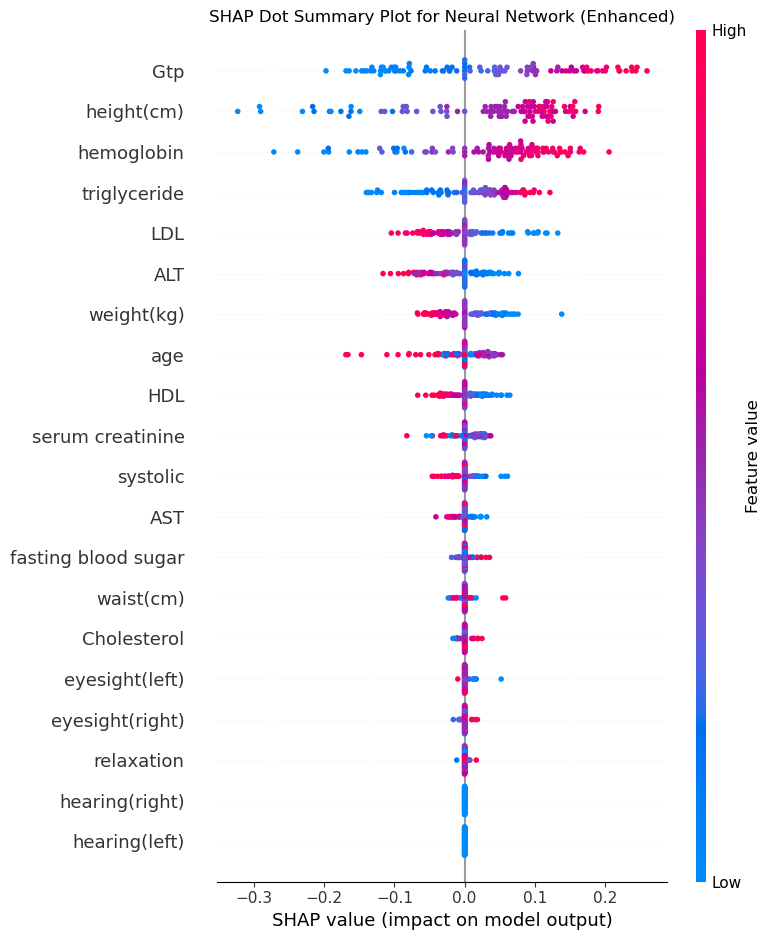


Generating SHAP bar plot with processed values...



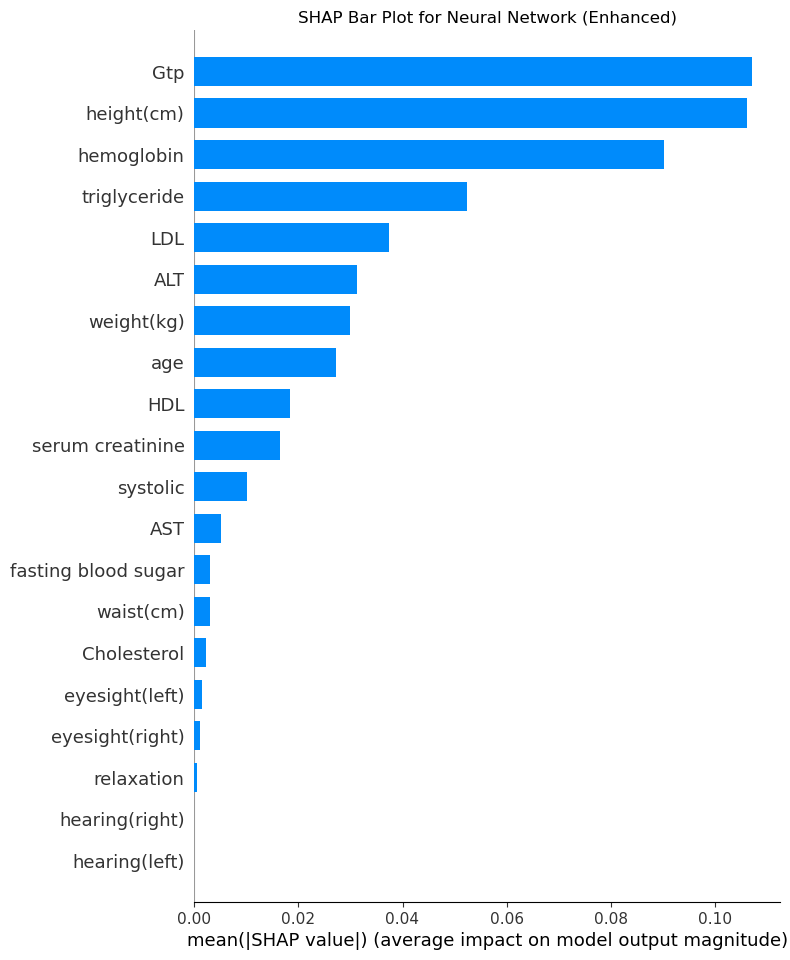

In [33]:
current_nn_model_to_explain = nn_model_enhanced
model_name_for_plot = "Neural Network (Enhanced)"

if 'current_nn_model_to_explain' in locals() and 'X_train_processed' in locals() and 'X_val_processed' in locals():
    print(f"\n--- {model_name_for_plot}: Calculating SHAP values ---\n")

    # SHAP requires a background dataset to integrate over.
    # A subset of the training data is used.
    background_data = shap.sample(X_train_processed, 100)
    explainer_nn = shap.KernelExplainer(current_nn_model_to_explain.predict, background_data)

    X_val_sample_for_shap = X_val_processed.sample(100, random_state=42) if len(X_val_processed) > 100 else X_val_processed

    shap_values_nn = explainer_nn.shap_values(X_val_sample_for_shap)

    print(f"<nOriginal shape of shap_values_nn: {shap_values_nn.shape}<n")

    # ---- THE FIX: Squeeze or reshape the shap_values_nn array ----
    if shap_values_nn.ndim == 3 and shap_values_nn.shape[-1] == 1:
        shap_values_nn_processed = shap_values_nn.squeeze(axis=-1)
        # Alternatively: shap_values_nn_processed = shap_values_nn[:, :, 0]
        print(f"Processed shape of shap_values_nn: {shap_values_nn_processed.shape}")
    else:
        # This case handles if shap_values_nn is already 2D or if it's a list (for multi-class)
        shap_values_nn_processed = shap_values_nn


    print("\nSHAP values processed. Generating summary plot...\n")

    if isinstance(shap_values_nn_processed, list):
        if len(shap_values_nn_processed) == 2 and shap_values_nn_processed[0].ndim == 2 :
             print("Plotting SHAP values for the positive class (class 1)")
             shap.summary_plot(shap_values_nn_processed[1], X_val_sample_for_shap,
                               feature_names=X_val_sample_for_shap.columns,
                               show=False, plot_type="dot")
        else:
             print("SHAP values are a list, plotting for the first element/class as example.")
             shap.summary_plot(shap_values_nn_processed[0], X_val_sample_for_shap,
                               feature_names=X_val_sample_for_shap.columns,
                               show=False, plot_type="dot")
    elif shap_values_nn_processed.ndim == 2:
        shap.summary_plot(shap_values_nn_processed, X_val_sample_for_shap,
                          feature_names=X_val_sample_for_shap.columns,
                          show=False, plot_type="dot")
    else:
        print(f"Error: Processed SHAP values have an unexpected shape: {shap_values_nn_processed.shape}")

    plt.title(f'SHAP Dot Summary Plot for {model_name_for_plot}')
    plt.tight_layout()
    plt.show()

    print("\nGenerating SHAP bar plot with processed values...\n")
    if isinstance(shap_values_nn_processed, list):
        if len(shap_values_nn_processed) == 2 and shap_values_nn_processed[0].ndim == 2:
            shap.summary_plot(shap_values_nn_processed[1], X_val_sample_for_shap, feature_names=X_val_sample_for_shap.columns, plot_type="bar", show=False)
        else:
            shap.summary_plot(shap_values_nn_processed[0], X_val_sample_for_shap, feature_names=X_val_sample_for_shap.columns, plot_type="bar", show=False)

    elif shap_values_nn_processed.ndim == 2:
        shap.summary_plot(shap_values_nn_processed, X_val_sample_for_shap, feature_names=X_val_sample_for_shap.columns, plot_type="bar", show=False)
    else:
        print("Cannot generate bar plot due to SHAP values shape.")

    plt.title(f'SHAP Bar Plot for {model_name_for_plot}')
    plt.show()

else:
    print("Neural Network model, X_train_processed, or X_val_processed not found for SHAP analysis.")
    print("Make sure to define 'current_nn_model_to_explain' and 'model_name_for_plot' before this cell.")

## 7. Model Performance Assessment and Comparison


--- Model Performance Comparison ---

                           Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
SVM                        0.782822   0.727168  0.905319  0.806523  0.848573   
Neural Network_Enhanced    0.786555   0.745269  0.870720  0.803125  0.859832   
Neural Network (Original)  0.782822   0.739136  0.874166  0.801000  0.857990   
Decision Tree              0.764841   0.705532  0.909124  0.794492  0.831362   
k-NN                       0.765343   0.727351  0.848898  0.783438  0.832485   

                           Training Time (s)  Validation Time (s)  
SVM                              2187.975705            63.357386  
Neural Network_Enhanced           217.236761             0.529175  
Neural Network (Original)          40.270106             0.407398  
Decision Tree                       0.283116             0.002170  
k-NN                                0.116034            35.035809  




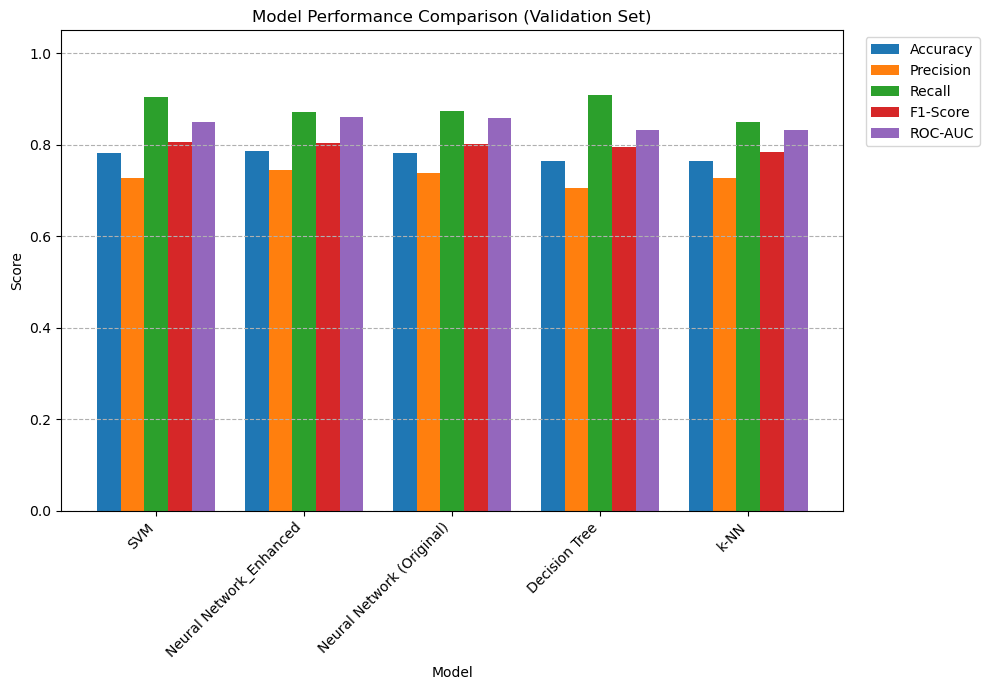

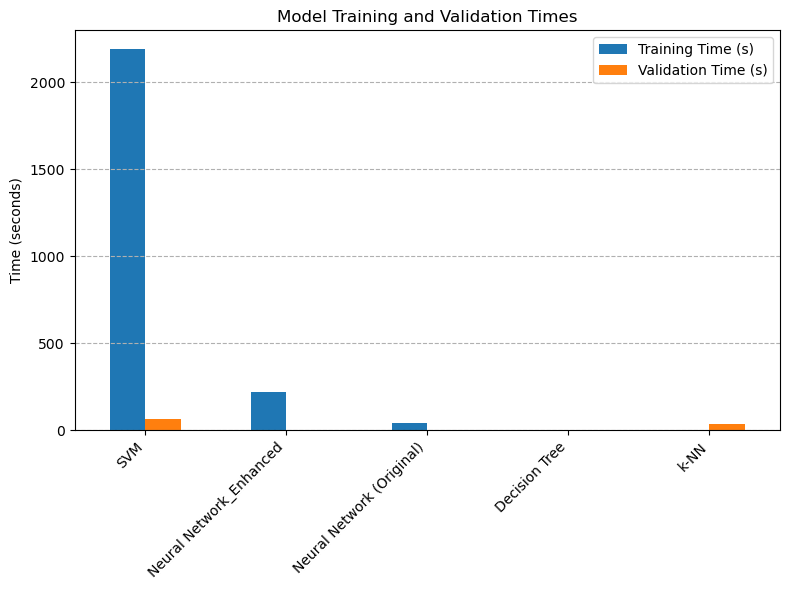

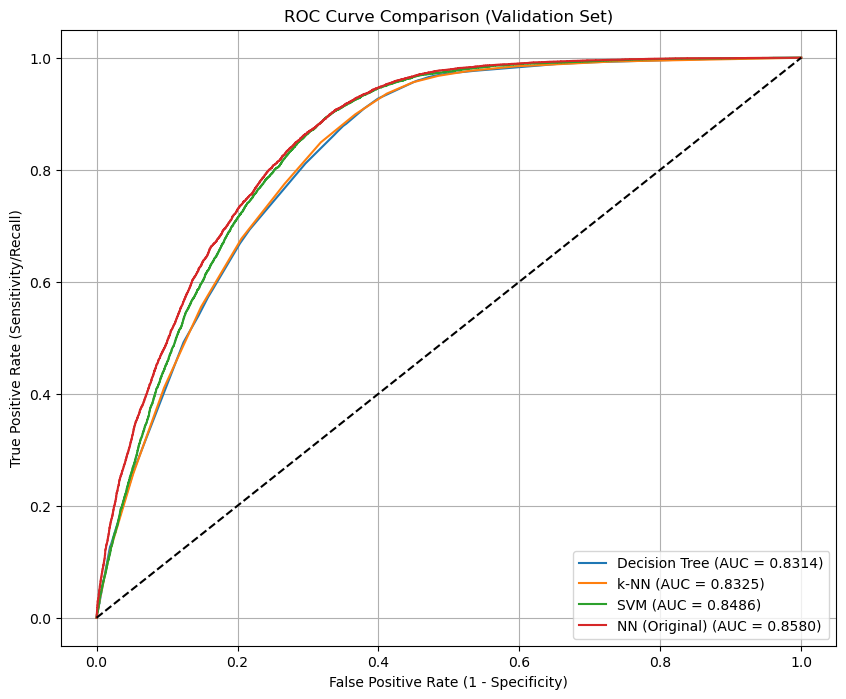

In [35]:
performance_df = pd.DataFrame(model_performance).T
performance_df['Training Time (s)'] = pd.Series(training_times)
performance_df['Validation Time (s)'] = pd.Series(validation_times)

# Sort by F1-Score (or another metric like ROC-AUC)
performance_df = performance_df.sort_values(by='F1-Score', ascending=False)

print("\n--- Model Performance Comparison ---\n")
print(performance_df)
print("\n")

# --- Plotting the performance metrics for comparison ---
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
n_metrics = len(metrics_to_plot)
model_names = performance_df.index
n_models = len(model_names)

fig, ax = plt.subplots(figsize=(max(10, n_models * n_metrics * 0.3), 7))

bar_width = 0.8 / n_metrics
index = np.arange(n_models)

for i, metric in enumerate(metrics_to_plot):
    offset = bar_width * i
    plt.bar(index + offset, performance_df[metric], bar_width, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Validation Set)')
plt.xticks(index + bar_width * (n_metrics - 1) / 2, model_names, rotation=45, ha="right")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print("\n")

# --- Plotting Training and Validation Times ---
times_df = performance_df[['Training Time (s)', 'Validation Time (s)']].copy()
times_df.plot(kind='bar', figsize=(max(8, n_models * 1.5), 6))
plt.title('Model Training and Validation Times')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print("\n")


# --- ROC Curve Comparison ---
plt.figure(figsize=(10, 8))

# Decision Tree
if 'best_dt_classifier' in locals() and hasattr(best_dt_classifier, 'predict_proba'):
    if 'Decision Tree' in model_performance and 'ROC-AUC' in model_performance['Decision Tree']:
        fpr_dt, tpr_dt, _ = roc_curve(y_val, best_dt_classifier.predict_proba(X_val_processed)[:,1])
        auc_dt = model_performance['Decision Tree']['ROC-AUC']
        plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.4f})")

# k-NN
if 'best_knn_classifier' in locals() and hasattr(best_knn_classifier, 'predict_proba'):
    if 'k-NN' in model_performance and 'ROC-AUC' in model_performance['k-NN']:
        fpr_knn, tpr_knn, _ = roc_curve(y_val, best_knn_classifier.predict_proba(X_val_processed)[:,1])
        auc_knn = model_performance['k-NN']['ROC-AUC']
        plt.plot(fpr_knn, tpr_knn, label=f"k-NN (AUC = {auc_knn:.4f})")

# SVM
if 'final_best_svm_classifier' in locals() and hasattr(final_best_svm_classifier, 'predict_proba'):
    if 'SVM' in model_performance and 'ROC-AUC' in model_performance['SVM']: # Adjust key if you used 'SVM_Randomized'
        fpr_svm, tpr_svm, _ = roc_curve(y_val, final_best_svm_classifier.predict_proba(X_val_processed)[:,1])
        auc_svm = model_performance['SVM']['ROC-AUC'] # Adjust key if needed
        plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.4f})")
elif 'best_svm_classifier' in locals() and hasattr(best_svm_classifier, 'predict_proba'): # Fallback if old name was used
    if 'SVM' in model_performance and 'ROC-AUC' in model_performance['SVM']:
        fpr_svm, tpr_svm, _ = roc_curve(y_val, best_svm_classifier.predict_proba(X_val_processed)[:,1])
        auc_svm = model_performance['SVM']['ROC-AUC']
        plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.4f})")


# Neural Network (Original Version)
if 'nn_model_original' in locals() and 'y_pred_proba_nn_original' in globals():
    if 'Neural Network (Original)' in model_performance and 'ROC-AUC' in model_performance['Neural Network (Original)']:
        fpr_nn_orig, tpr_nn_orig, _ = roc_curve(y_val, y_pred_proba_nn_original)
        auc_nn_orig = model_performance['Neural Network (Original)']['ROC-AUC']
        plt.plot(fpr_nn_orig, tpr_nn_orig, label=f"NN (Original) (AUC = {auc_nn_orig:.4f})")

# Neural Network (Enhanced Version)
if 'nn_model_enhanced' in locals() and 'y_pred_proba_nn_enhanced' in globals():
    if 'Neural Network (Enhanced)' in model_performance and 'ROC-AUC' in model_performance['Neural Network (Enhanced)']:
        fpr_nn_enh, tpr_nn_enh, _ = roc_curve(y_val, y_pred_proba_nn_enhanced)
        auc_nn_enh = model_performance['Neural Network (Enhanced)']['ROC-AUC']
        plt.plot(fpr_nn_enh, tpr_nn_enh, label=f"NN (Enhanced) (AUC = {auc_nn_enh:.4f})")


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve Comparison (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()